https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset

In [152]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
import xgboost as xgb

In [2]:
pd.set_option('display.max_rows', None)

In [3]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")

In [4]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


### DO PRZEANALIZOWANIA

* Zamienić gender na 0-1, analogicznie ever_married, work_type, Residence_type, smoking_status +
* Usunąć id +
* zabezpieczyć braki danych w bmi
* sprawdzić dziwne wartości (typu wiek = 0 itp.):
    * sprawdzić min wiek - prawdopodobnie w work_type oznaczenie children oznacza, że to ejst dziecko i te wartości wieku będą ok +
    * sprawdzić max bmi +
    * sprawdzić zakresy poziomu glukozy (wg kaggle we krwi) +
* zamienić nazwę Residence_type na residence_type +
* Boxploty, korelacje, histogramy +
* sprawdzić wykresy dla bmi po uzupełnieniu NaN lub Unknown


### Problemy ze zbiorem:
* nie wiemy, skąd pochodzą dane - w związku z tym nie wiemy, czy np. pracujące dzieci odnosić do USA, Bangladeszu czy innego kraju
* Nie mamy danych środowiskowych - w związku z tym nie wiemy, czy np. palące dzieci lub z nadwagą mogą być błędami danych
* Mamy dość mało danych o stanie pacjentów - np. poziom glukozy dla kobiet może być podwyższony, jeśli są one w ciąży
Podsumowując - mamy mało danych, co z jednej strony jest spoko, ale z drugiej możemy nie mieć informacji, która podwyższyłaby skutecznośc modeli.

### DO PRZEDSTAWIENIA W PREZENTACJI

1. Wartości wieku - poniżej 2 lat wiek podany po przecinku - - przedstawienie, że wartości są w porządku
2. Wartości work_type i dziwne wartości dla wieku
3. Poziomy glukozy - przedstawienie, że one są w porządku
4. Występowanie płci "inne" w zawrotnej liczbie 1 sztuka

Co zrobiliśmy ze zbiorem danych:
0. Zbadanie wartości poszczególnych kolumn (do połączenia w prezentacji z powyższym)
1. Usunięcie kolumny id
2. Ustandaryzowanie nazw kolumn



#### Usunięcie id

In [5]:
df = df.drop('id', axis = 1)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


#### Analiza eksploracyjna

In [6]:
df.shape

(5110, 11)

In [7]:
df.info()
#w bmi są braki danych

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


In [8]:
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


#### Ustandaryzowanie nazw kolumn

In [9]:
df.rename(columns = {'Residence_type':'residence_type'}, inplace = True)

#### Powrót do analizy eksploracyjnej

In [10]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [11]:
df.hypertension.value_counts()

0    4612
1     498
Name: hypertension, dtype: int64

In [12]:
df.heart_disease.value_counts()

0    4834
1     276
Name: heart_disease, dtype: int64

In [13]:
df.gender.value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

In [14]:
df.ever_married.value_counts()

Yes    3353
No     1757
Name: ever_married, dtype: int64

In [15]:
df.residence_type.value_counts()

Urban    2596
Rural    2514
Name: residence_type, dtype: int64

In [16]:
df.smoking_status.value_counts()
#Unknown to w sumie taki brak danych, a tego jest dość sporo

never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64

In [17]:
df.work_type.value_counts()

Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

In [18]:
df.age.value_counts().sort_index().head(25)
#UWAGA - do 2 r.ż. wiek jest podany po przecinku (prawdopodobnie to jest liczba dni / 365)

0.08     2
0.16     3
0.24     5
0.32     5
0.40     2
0.48     3
0.56     5
0.64     4
0.72     5
0.80     4
0.88     5
1.00     5
1.08     8
1.16     4
1.24     8
1.32     8
1.40     3
1.48     6
1.56     4
1.64     8
1.72     6
1.80     9
1.88     8
2.00    55
3.00    46
Name: age, dtype: int64

In [19]:
df[(df['age']>0) & (df['age']<2)].age.count()

120

In [20]:
#Sprawdzenie, czy wszyscy pacjenci poniżej 2 lat są oznaczeni jako dzieciaki
df[(df['age']>0) & (df['age']<2)].work_type.value_counts()

children    120
Name: work_type, dtype: int64

In [21]:
df.groupby(['work_type'])['age'].agg([min, max, 'count'])
# No fajnie xD pracujące dzieciaki xD

,min,max,count
work_type,,,
Govt_job,14.00,82.0,657
Never_worked,13.00,23.0,22
Private,8.00,82.0,2925
Self-employed,7.00,82.0,819
children,0.08,16.0,687


In [22]:
df.query('age == 16.0 & work_type == "Private"')

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
538,Female,16.0,0,0,No,Private,Rural,155.43,27.3,never smoked,0
681,Female,16.0,0,0,No,Private,Rural,74.98,21.4,never smoked,0
972,Female,16.0,0,0,No,Private,Urban,87.98,22.4,never smoked,0
1469,Female,16.0,0,0,No,Private,Rural,70.15,21.5,Unknown,0
1726,Female,16.0,0,0,No,Private,Urban,58.02,22.5,Unknown,0
1744,Male,16.0,0,0,No,Private,Rural,122.46,18.7,never smoked,0
1763,Male,16.0,0,0,No,Private,Rural,111.93,32.2,never smoked,0
1821,Male,16.0,0,0,No,Private,Rural,133.20,26.3,Unknown,0
2195,Male,16.0,0,0,No,Private,Urban,134.80,22.4,never smoked,0
2254,Female,16.0,0,0,No,Private,Rural,94.03,25.7,never smoked,0


In [23]:
df.query('age <16  & work_type == "Private"')

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
251,Female,8.0,0,0,No,Private,Urban,110.89,17.6,Unknown,0
455,Male,13.0,0,0,No,Private,Urban,92.14,23.2,never smoked,0
950,Male,15.0,0,0,No,Private,Urban,57.94,41.7,Unknown,0
1039,Female,15.0,0,0,No,Private,Rural,95.43,25.0,Unknown,0
1063,Female,13.0,0,0,No,Private,Rural,60.69,24.0,smokes,0
1197,Female,14.0,0,0,No,Private,Rural,84.46,21.8,Unknown,0
1242,Male,15.0,0,0,No,Private,Rural,61.61,27.8,never smoked,0
1249,Male,15.0,0,0,No,Private,Rural,78.59,25.1,Unknown,0
1265,Female,14.0,0,0,No,Private,Rural,118.81,24.7,Unknown,0
1623,Female,15.0,0,0,No,Private,Rural,69.38,28.4,never smoked,0


In [24]:
# Na kagglu nic nie ma, co to może znaczyć, może dzieciaki pomagają rodzicom w rodzinnym biznesie
# albo łapały jakieś wakacyjne roboty/staże albo różni ludzie zbierali dane i jeden oznaczył children, a drugi never_worked.

#### poziom cukru we krwi
https://www.nn.pl/blog/posts/2021/jaki-powinien-byc-poziom-cukru-we-krwi.html
70 - 140 - dorośli
80 - 180 - osoby starsze
80 - 100 - dzieci (na czczo)

https://www.medonet.pl/badania,poziom-cukru-we-krwi---normy--tabela--objawy-hiper--i-hipoglikemii,artykul,1585409.html#jak-mierzy-sie-poziom-cukru-we-krwi
powyżej 200 - cukrzyca

kobiety w ciąży mogą mieć wyższy poziom (180)

In [25]:
# W naszych danych min i max jest w porządku - mamy cukrzyków w danych i osoby bliskie hipoglikemii

#### bmi

##### Normy bmi
https://www.medicover.pl/kalkulator/bmi/
<br>
<16 - wygłodzenie <br>
\>= 40 - otyłość III stopnia

bardziej przydatne byłyby zmienne wzrost i waga niż wyliczone bmi, ponieważ dla dzieciaków właściwie nie do końca powinno
się takie coś liczyć; osoby starsze też mają mniej mięśni, więc dla nich ten wskaźnik inaczej się interpretuje niż u młodszych osób

In [26]:
df['bmi'].isna().sum()

201

In [27]:
df.bmi.value_counts().sort_index().tail(10)
# mamy wartości ponad 90 - z jednej strony wydaje się to trochę przegięte, z drugiej strony przy wadze 310 kg i wzroście 180cm
# bmi wychodzi 95, więc jak na moje to jest możliwe, zwłaszcza że najgrubszy człowiek świata ważył ponad 600 kg

61.2    1
61.6    1
63.3    1
64.4    1
64.8    1
66.8    1
71.9    1
78.0    1
92.0    1
97.6    1
Name: bmi, dtype: int64

In [28]:
# bmi w większośći przypadków bedzie niższe u dzieci
df.groupby(['work_type'])['bmi'].agg([min, max, 'mean', 'count'])

,min,max,mean,count
work_type,,,,
Govt_job,16.0,57.7,30.522063,630
Never_worked,14.6,44.9,25.545455,22
Private,11.5,97.6,30.304625,2811
Self-employed,11.3,64.8,30.211871,775
children,10.3,41.7,20.038003,671


In [29]:
df['age_cat'] = np.where(df['age']<= 16, '16 or less',
                   np.where(df['age']<30, '17 - 29',
                   np.where(df['age']<45, '30 - 44',
                   np.where(df['age']<65, '45 - 59', '60 or greater'))))

In [30]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_cat
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,60 or greater
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1,45 - 59
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1,60 or greater
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1,45 - 59
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1,60 or greater


In [31]:
df['age_cat'].value_counts()

45 - 59          1550
60 or greater    1027
30 - 44          1018
16 or less        796
17 - 29           719
Name: age_cat, dtype: int64

In [32]:
df.groupby(['age_cat'])['bmi'].agg([min, max, 'mean', 'count'])

,min,max,mean,count
age_cat,,,,
16 or less,10.3,48.8,20.787661,778
17 - 29,16.0,97.6,27.991489,705
30 - 44,11.5,92.0,31.270978,982
45 - 59,14.2,66.8,31.558753,1491
60 or greater,11.3,54.6,29.557083,953


In [33]:
null_bmi_df = df[df['bmi'].isnull()]

In [34]:
null_bmi_df.describe()
# nulle są nie tylko u noworodków

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,201.000000,201.000000,201.000000,201.000000,0.0,201.000000
mean,52.049154,0.233831,0.164179,126.724627,NaN,0.199005
std,22.276181,0.424323,0.371363,59.240322,NaN,0.400249
min,0.480000,0.000000,0.000000,57.520000,NaN,0.000000
25%,37.000000,0.000000,0.000000,81.430000,NaN,0.000000
50%,58.000000,0.000000,0.000000,99.870000,NaN,0.000000
75%,71.000000,0.000000,0.000000,191.790000,NaN,0.000000
max,82.000000,1.000000,1.000000,260.850000,NaN,1.000000


In [35]:
null_bmi_df.groupby(['age_cat'])['age_cat'].count()
#właściwie najwięcej nulli w bmi jest u osób starszych

age_cat
16 or less       18
17 - 29          14
30 - 44          36
45 - 59          59
60 or greater    74
Name: age_cat, dtype: int64

***

### Wykresy

In [36]:
col_list = df[['age', 'avg_glucose_level', 'bmi']].columns.tolist()

In [37]:
col_list

['age', 'avg_glucose_level', 'bmi']

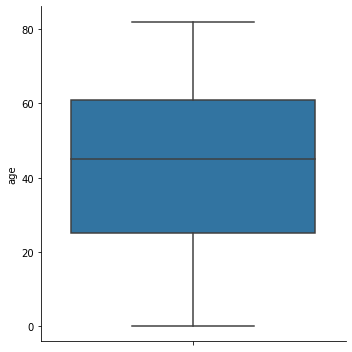

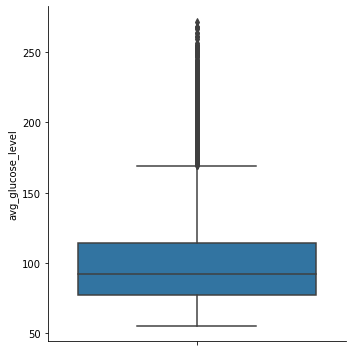

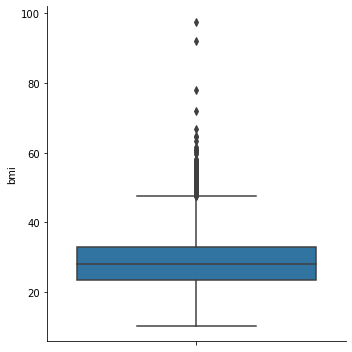

In [38]:
for var in col_list:
    sns.catplot(data=df, y=var, kind='box');

In [39]:
features = df[col_list].values.tolist()

In [40]:
def histogram(df: pd.DataFrame, col_list: list, n_bin: int = 6):
    for col in col_list:
        plt.figure(figsize = (12,10))
        plt.hist(df[col], bins = n_bin)
        plt.title(col)

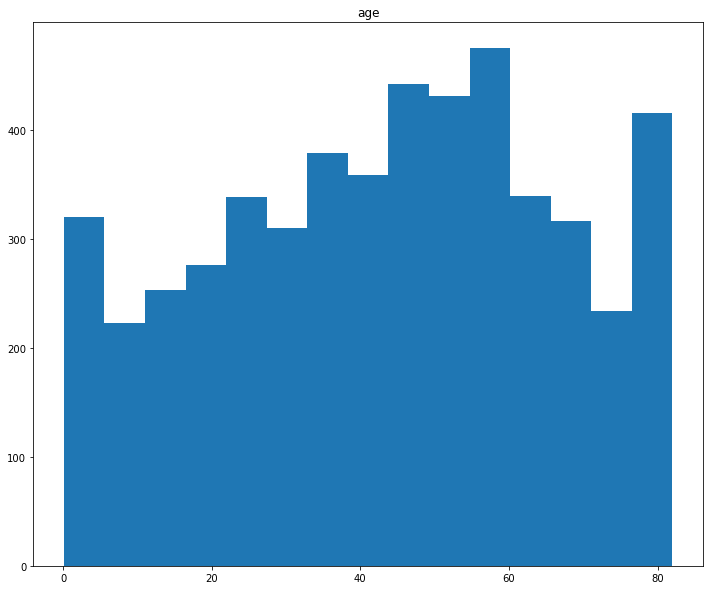

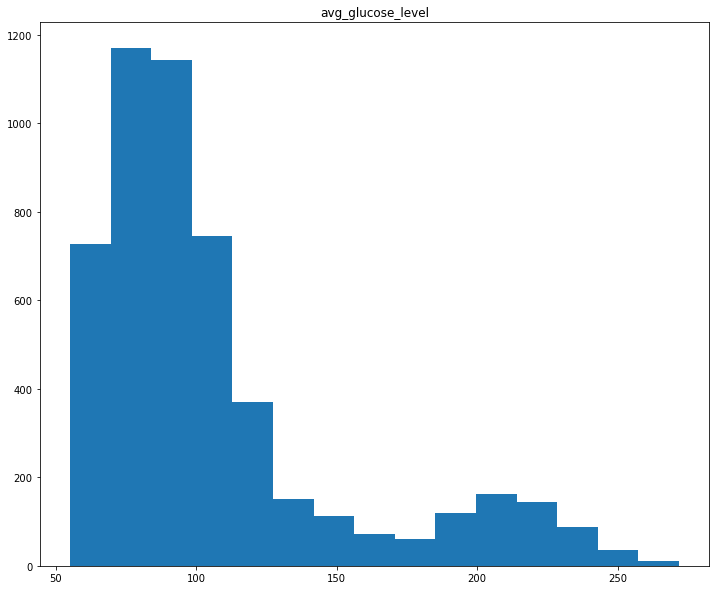

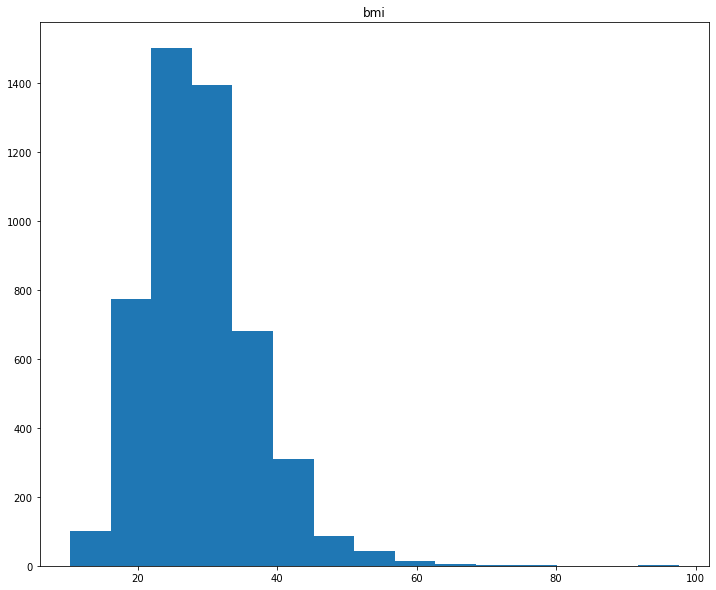

In [41]:
histogram(df, col_list=col_list, n_bin= 15 )

#### Wnioski z powyższych wykresów:

Rozkłady na oko nie są normalne.
* Rozkład wieku jest bardzo zrównoważony
* Poziom glukozy wyodrębnia grupę cukrzyków
* Rozkład bmi jest najbardziej zbliżony do rozkładu normalnego, lecz posiada długi ogon, wyodrębniając ludzi otyłych

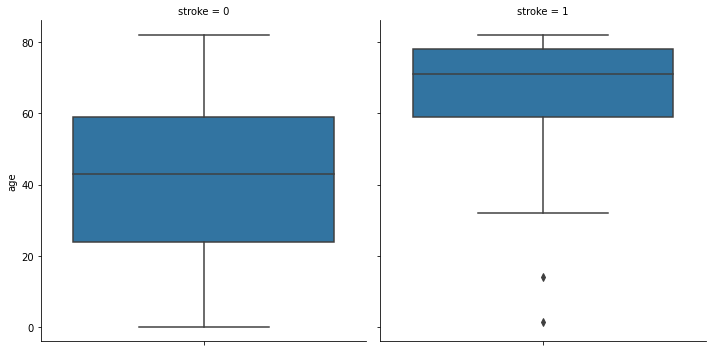

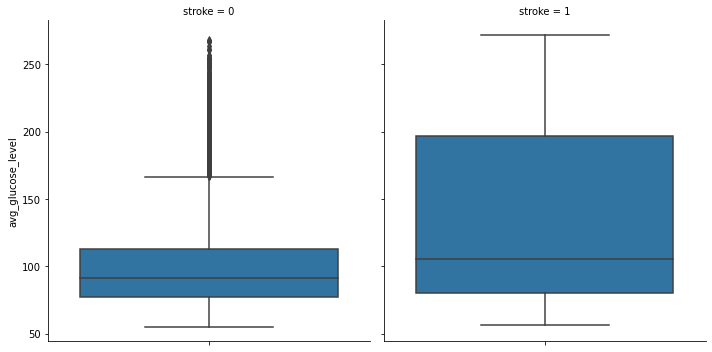

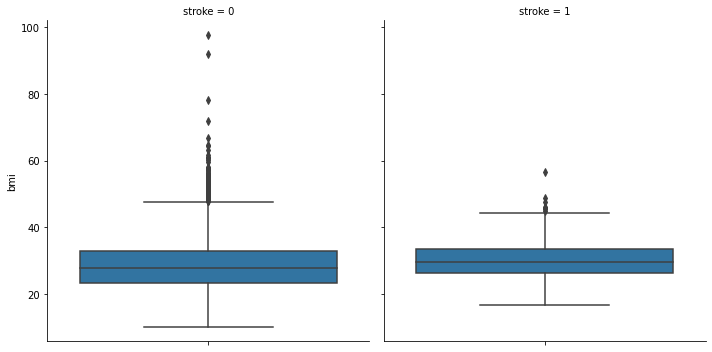

In [42]:
for var in col_list:
    sns.catplot(data=df, y=var, col = 'stroke', kind='box');

#### Wnioski z powyższych wykresów:

* Ryzyko udaru dla osób starszych jest większe, co jest naturalną zależnością
* Udar u cukrzyków jest bardziej prawdopodobny (co chyba też jest dość naturalną zależnością)
* bmi do sprawdzenia, czy będzie dobrym klasyfikatorem - **zamiana na kategorie**

### Kopia pliku

In [43]:
df_checkpoint_1 = df.copy()

In [44]:
df_checkpoint_1.groupby(['stroke','smoking_status'])['gender'].count().reset_index()
#zostawiamy tę zmienną

,stroke,smoking_status,gender
0,0,Unknown,1497
1,0,formerly smoked,815
2,0,never smoked,1802
3,0,smokes,747
4,1,Unknown,47
5,1,formerly smoked,70
6,1,never smoked,90
7,1,smokes,42


### One Hot Encoding

In [45]:
df = pd.get_dummies(df, columns=['gender', 'ever_married', 'work_type', 'residence_type', 'smoking_status'])

In [46]:
df.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,age_cat,gender_Female,gender_Male,gender_Other,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,residence_type_Rural,residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.6,1,60 or greater,0,1,0,...,0,1,0,0,0,1,0,1,0,0
1,61.0,0,0,202.21,NaN,1,45 - 59,1,0,0,...,0,0,1,0,1,0,0,0,1,0
2,80.0,0,1,105.92,32.5,1,60 or greater,0,1,0,...,0,1,0,0,1,0,0,0,1,0
3,49.0,0,0,171.23,34.4,1,45 - 59,1,0,0,...,0,1,0,0,0,1,0,0,0,1
4,79.0,1,0,174.12,24.0,1,60 or greater,1,0,0,...,0,0,1,0,1,0,0,0,1,0


In [47]:
### Korelacje

In [48]:
df.corr(method='spearman')

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,gender_Other,ever_married_No,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,residence_type_Rural,residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
age,1.000000,0.280647,0.269627,0.145168,0.375650,0.249531,0.019598,-0.019268,-0.011676,-0.664408,...,-0.078914,0.089099,0.328754,-0.589511,-0.014158,0.014158,-0.353916,0.236744,0.104208,0.062572
hypertension,0.280647,1.000000,0.108306,0.114041,0.167493,0.127904,-0.021143,0.021275,-0.004597,-0.164243,...,-0.021608,-0.005413,0.115442,-0.129506,0.007913,-0.007913,-0.141501,0.058853,0.065063,0.031240
heart_disease,0.269627,0.108306,1.000000,0.106360,0.066144,0.134914,-0.085617,0.085717,-0.003343,-0.114644,...,-0.015712,0.000027,0.086760,-0.091634,-0.003092,0.003092,-0.066731,0.066804,-0.021856,0.044049
avg_glucose_level,0.145168,0.114041,0.106360,1.000000,0.114370,0.082541,-0.049113,0.048641,0.016744,-0.098379,...,-0.008346,0.013114,0.030928,-0.053113,0.013411,-0.013411,-0.053263,0.034725,0.012447,0.014688
bmi,0.375650,0.167493,0.066144,0.114370,1.000000,0.055445,-0.000070,0.000504,-0.014953,-0.385833,...,-0.033397,0.213132,0.092733,-0.487774,-0.001139,0.001139,-0.298561,0.126545,0.112577,0.097796
stroke,0.249531,0.127904,0.134914,0.082541,0.055445,1.000000,-0.009027,0.009117,-0.003166,-0.108340,...,-0.014882,0.011888,0.062168,-0.083869,-0.015458,0.015458,-0.055892,0.064556,-0.004129,0.008939
gender_Female,0.019598,-0.021143,-0.085617,-0.049113,-0.000070,-0.009027,1.000000,-0.999597,-0.016642,-0.030483,...,-0.011469,0.032294,0.026143,-0.089120,-0.006340,0.006340,-0.059393,-0.043603,0.099111,-0.011306
gender_Male,-0.019268,0.021275,0.085717,0.048641,0.000504,0.009117,-0.999597,1.000000,-0.011757,0.029936,...,0.011496,-0.032639,-0.025971,0.089283,0.005937,-0.005937,0.059658,0.042738,-0.098813,0.011477
gender_Other,-0.011676,-0.004597,-0.003343,0.016744,-0.014953,-0.003166,-0.016642,-0.011757,1.000000,0.019327,...,-0.000920,0.012092,-0.006112,-0.005514,0.014217,-0.014217,-0.009206,0.030568,-0.010728,-0.005978
ever_married_No,-0.664408,-0.164243,-0.114644,-0.098379,-0.385833,-0.108340,-0.030483,0.029936,0.019327,1.000000,...,0.090838,-0.153830,-0.192716,0.544441,0.006261,-0.006261,0.332081,-0.171256,-0.102845,-0.105226


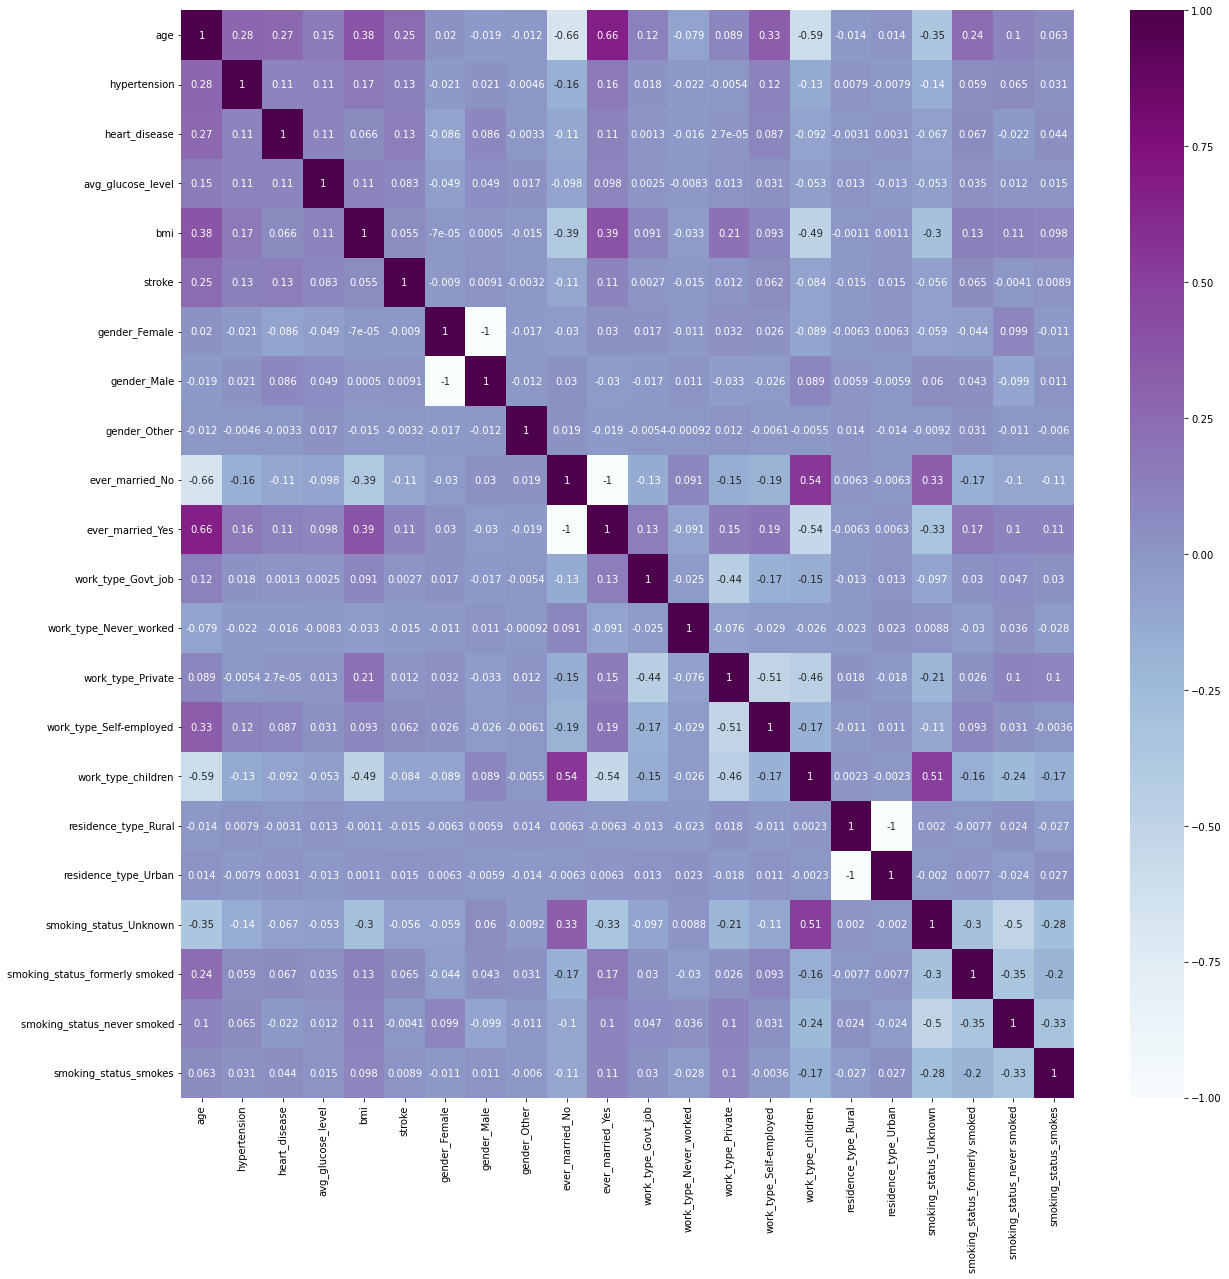

In [49]:
# Heatmapa dla korelacji
plt.figure(figsize = (20,20)) #rozmiar wykresu
sns.color_palette("viridis", as_cmap=True) #paleta kolorów, parametr as_cmap skaluje liczby na kolor (RGB)
Var_Corr = df.corr(method='spearman')
sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns, annot=True, cmap="BuPu");

#### Usunięcie NaN w bmi

In [50]:
df = df.dropna()

In [51]:
df.shape

(4909, 23)

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4909 entries, 0 to 5109
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             4909 non-null   float64
 1   hypertension                    4909 non-null   int64  
 2   heart_disease                   4909 non-null   int64  
 3   avg_glucose_level               4909 non-null   float64
 4   bmi                             4909 non-null   float64
 5   stroke                          4909 non-null   int64  
 6   age_cat                         4909 non-null   object 
 7   gender_Female                   4909 non-null   uint8  
 8   gender_Male                     4909 non-null   uint8  
 9   gender_Other                    4909 non-null   uint8  
 10  ever_married_No                 4909 non-null   uint8  
 11  ever_married_Yes                4909 non-null   uint8  
 12  work_type_Govt_job              49

In [53]:
df.stroke.value_counts()

0    4700
1     209
Name: stroke, dtype: int64

In [54]:
df = df.drop('age_cat', axis = 1)

In [55]:
df.columns

Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi',
       'stroke', 'gender_Female', 'gender_Male', 'gender_Other',
       'ever_married_No', 'ever_married_Yes', 'work_type_Govt_job',
       'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children', 'residence_type_Rural',
       'residence_type_Urban', 'smoking_status_Unknown',
       'smoking_status_formerly smoked', 'smoking_status_never smoked',
       'smoking_status_smokes'],
      dtype='object')

In [56]:
df2 = df.copy()

In [57]:
df2['bmi'] = np.where(df2['bmi']< 18.5, 1,
                   np.where(df2['bmi']<25, 2,
                   np.where(df2['bmi']<30, 3,
                   np.where(df2['bmi']<35, 4,
                   np.where(df2['bmi']<40, 5,6 )))))

In [58]:
df2.head(5)

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,gender_Other,ever_married_No,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,residence_type_Rural,residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,5,1,0,1,0,0,...,0,1,0,0,0,1,0,1,0,0
2,80.0,0,1,105.92,4,1,0,1,0,0,...,0,1,0,0,1,0,0,0,1,0
3,49.0,0,0,171.23,4,1,1,0,0,0,...,0,1,0,0,0,1,0,0,0,1
4,79.0,1,0,174.12,2,1,1,0,0,0,...,0,0,1,0,1,0,0,0,1,0
5,81.0,0,0,186.21,3,1,0,1,0,0,...,0,1,0,0,0,1,0,1,0,0


***

***

### Podział na zbiór treningowy, walidacyjny i testowy

In [59]:
from sklearn.model_selection import train_test_split, GridSearchCV

In [60]:
X = df.drop('stroke', axis = 1)
y = df['stroke']

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state=42)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state=42)

In [62]:
X_train.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Male,gender_Other,ever_married_No,ever_married_Yes,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,residence_type_Rural,residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
3565,40.0,0,0,65.77,31.2,1,0,0,0,1,...,0,1,0,0,0,1,0,0,1,0
898,59.0,0,0,81.64,32.8,1,0,0,0,1,...,0,0,1,0,0,1,1,0,0,0
2707,57.0,0,0,217.40,36.6,1,0,0,0,1,...,0,1,0,0,0,1,0,0,1,0
4198,81.0,0,0,71.18,23.9,0,1,0,0,1,...,0,0,1,0,0,1,0,1,0,0
2746,65.0,0,0,95.88,28.5,0,1,0,0,1,...,0,0,1,0,0,1,0,0,1,0


In [63]:
features_name = list(df.columns)
features_out = ['age_cat']
features_name = [x for x in features_name if x not in features_out]

In [64]:
features_name

['age',
 'hypertension',
 'heart_disease',
 'avg_glucose_level',
 'bmi',
 'stroke',
 'gender_Female',
 'gender_Male',
 'gender_Other',
 'ever_married_No',
 'ever_married_Yes',
 'work_type_Govt_job',
 'work_type_Never_worked',
 'work_type_Private',
 'work_type_Self-employed',
 'work_type_children',
 'residence_type_Rural',
 'residence_type_Urban',
 'smoking_status_Unknown',
 'smoking_status_formerly smoked',
 'smoking_status_never smoked',
 'smoking_status_smokes']

In [65]:
X_train.shape

(3927, 21)

In [66]:
X_test.shape

(982, 21)

In [67]:
y_train.shape

(3927,)

In [68]:
y_test.shape

(982,)

In [69]:
y_train.value_counts()

0    3771
1     156
Name: stroke, dtype: int64

In [70]:
y_test.value_counts()

0    929
1     53
Name: stroke, dtype: int64

***

### Standaryzacja danych

In [71]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, precision_score, f1_score, precision_recall_curve
# from sklearn.model_selection import GridSearchCV

In [153]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

***

### Modele

## Drzewo decyzyjne

In [73]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from collections import Counter

In [74]:
# Sprawdzenie pojedynczego drzewa (jeden zestaw parametrów)

In [75]:
drzewo = DecisionTreeClassifier(criterion= 'entropy', class_weight= {0: 1, 1: 10}, max_depth= 4, max_features= 9, random_state = 42)
drzewo.fit(X_train, y_train)
y_pred = drzewo.predict(X_test)

In [76]:
f1 = f1_score(y_test, y_pred)

In [77]:
f1

0.16058394160583941

In [78]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.92      0.94       929
           1       0.13      0.21      0.16        53

    accuracy                           0.88       982
   macro avg       0.54      0.56      0.55       982
weighted avg       0.91      0.88      0.90       982



In [79]:
# PRÓBA GRID SEARCH

In [80]:
param_drzewo = {"max_depth": [3,4],
              "max_features": list(range(3,4)),
                "class_weight": [{0: 1, 1: 1}]
             }


In [81]:
rf_classifier = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(rf_classifier, param_grid=param_drzewo, cv=5, scoring = ['f1','recall'], refit = 'f1', verbose=0)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'class_weight': [{0: 1, 1: 1}], 'max_depth': [3, 4],
                         'max_features': [3]},
             refit='f1', scoring=['f1', 'recall'])

In [82]:
grid_search.cv_results_
#splitx_test_score pokazuje teraz recall, który wynosi 0, bo algorytm wrzuca wszystko do jednego

{'mean_fit_time': array([0.00320077, 0.00300078]),
 'std_fit_time': array([3.98998489e-04, 1.20064529e-06]),
 'mean_score_time': array([0.00299845, 0.00340543]),
 'std_score_time': array([7.47889859e-07, 1.35575582e-03]),
 'param_class_weight': masked_array(data=[{0: 1, 1: 1}, {0: 1, 1: 1}],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[3, 4],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_max_features': masked_array(data=[3, 3],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'class_weight': {0: 1, 1: 1}, 'max_depth': 3, 'max_features': 3},
  {'class_weight': {0: 1, 1: 1}, 'max_depth': 4, 'max_features': 3}],
 'split0_test_f1': array([0., 0.]),
 'split1_test_f1': array([0., 0.]),
 'split2_test_f1': array([0., 0.]),
 'split3_test_f1': array([0., 0.]),
 'split4_test_f1': array([0., 0.]),
 'mean_test_f1': array

In [83]:
grid_search.best_score_ 

0.0

In [84]:
grid_search.scorer_ 

{'f1': make_scorer(f1_score, average=binary),
 'recall': make_scorer(recall_score, average=binary)}

In [85]:
#sprawdzenie accuracy

In [86]:
grid_search = GridSearchCV(rf_classifier, param_grid=param_drzewo, cv=5, verbose=0)
grid_search.fit(X_train, y_train)

grid_search.cv_results_
#splitx_test_score pokazuje teraz recall, który wynosi 0, bo algorytm wrzuca wszystko do jednego

{'mean_fit_time': array([0.00320001, 0.00340023]),
 'std_fit_time': array([0.00040033, 0.00080078]),
 'mean_score_time': array([0.0013999 , 0.00159945]),
 'std_score_time': array([0.00049084, 0.00079991]),
 'param_class_weight': masked_array(data=[{0: 1, 1: 1}, {0: 1, 1: 1}],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[3, 4],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_max_features': masked_array(data=[3, 3],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'class_weight': {0: 1, 1: 1}, 'max_depth': 3, 'max_features': 3},
  {'class_weight': {0: 1, 1: 1}, 'max_depth': 4, 'max_features': 3}],
 'split0_test_score': array([0.9605598, 0.9605598]),
 'split1_test_score': array([0.95928753, 0.95928753]),
 'split2_test_score': array([0.96050955, 0.96050955]),
 'split3_test_score': array([0.96050955, 0.96050955]),


In [87]:
print(grid_search.best_index_ )

0


In [88]:
grid_search.best_score_ #wybiera średnią z walidacji krzyżowej ze wszystkich kombinacji parametrów - w tym przykładzie
# oba algorytmy wrzucają wszystko do jedynek i mają tę samą wartość, więc wskazało pierwszy model

0.9602751981329314

In [89]:
grid_search.best_params_

{'class_weight': {0: 1, 1: 1}, 'max_depth': 3, 'max_features': 3}

In [90]:
# KONIEC PRÓBA GRID SEARCH

In [91]:
 GridSearchCV?

In [92]:
drzewo = DecisionTreeClassifier(random_state = 42)

param_drzewo = {"max_depth": [3, 4, 5, 6, 7],
                "criterion": ['entropy', 'gini'],
              "max_features": list(range(3,10)),
                "class_weight": [{0: 1, 1: 1}, {0: 1, 1: 5}, {0: 2, 1: 5}, {0: 1, 1: 10},{0: 1, 1: 15}, {0: 2, 1: 15}]
             }

In [102]:
param_drzewo_samp = {"max_depth": [3, 4, 5, 6, 7],
                "criterion": ['entropy', 'gini'],
              "max_features": list(range(3,10)),
                     }

In [93]:
#grid search definition
def grid_search(classifier, param_grid, scoring, refit = 'f1', cross_val = 0):
    if cross_val == 0:
        return GridSearchCV(classifier, param_grid=param_grid, scoring = scoring, refit = refit, verbose=0)
    if cross_val == 1:
        return GridSearchCV(classifier, param_grid=param_grid, scoring = scoring, refit = refit, verbose=0)
    if cross_val >= 2:
        return GridSearchCV(classifier, param_grid=param_grid, scoring = scoring, refit = refit, verbose=0, cv = cross_val)

# grid_search.fit(X, y)

F:\Anaconda\envs\projekt_python\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Anaconda\envs\projekt_python\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Anaconda\envs\projekt_python\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Anaconda\envs\projekt_python\lib\site-packages\sklearn\metrics\_classification.py:1318: Undefi

F:\Anaconda\envs\projekt_python\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Anaconda\envs\projekt_python\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Anaconda\envs\projekt_python\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Anaconda\envs\projekt_python\lib\site-packages\sklearn\metrics\_classification.py:1318: Undefi

F:\Anaconda\envs\projekt_python\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Anaconda\envs\projekt_python\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Anaconda\envs\projekt_python\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Anaconda\envs\projekt_python\lib\site-packages\sklearn\metrics\_classification.py:1318: Undefi

F:\Anaconda\envs\projekt_python\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Anaconda\envs\projekt_python\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Anaconda\envs\projekt_python\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Anaconda\envs\projekt_python\lib\site-packages\sklearn\metrics\_classification.py:1318: Undefi

F:\Anaconda\envs\projekt_python\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Anaconda\envs\projekt_python\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Anaconda\envs\projekt_python\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Anaconda\envs\projekt_python\lib\site-packages\sklearn\metrics\_classification.py:1318: Undefi

F:\Anaconda\envs\projekt_python\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Anaconda\envs\projekt_python\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Anaconda\envs\projekt_python\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Anaconda\envs\projekt_python\lib\site-packages\sklearn\metrics\_classification.py:1318: Undefi

F:\Anaconda\envs\projekt_python\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Anaconda\envs\projekt_python\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Anaconda\envs\projekt_python\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Anaconda\envs\projekt_python\lib\site-packages\sklearn\metrics\_classification.py:1318: Undefi

F:\Anaconda\envs\projekt_python\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Anaconda\envs\projekt_python\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Anaconda\envs\projekt_python\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Anaconda\envs\projekt_python\lib\site-packages\sklearn\metrics\_classification.py:1318: Undefi

Liczba kroswalidacji: 0 
 Liczba obserwacji w zbiorze treningowym: [(0, 3771), (1, 156)] 
 Sprawdzana metryka: recall 
 Najlepsza wartość metryki: 0.808467741935484 
 Pozostałe score'y: {'f1': 0.16397065706257696, 'recall': 0.808467741935484, 'precision': 0.09137882733342384, 'accuracy': 0.6707281891703538, 'roc_auc': 0.7823611572503438} 
 
 Najlepsze parametry: {'class_weight': {0: 1, 1: 15}, 'criterion': 'gini', 'max_depth': 3, 'max_features': 8} 
 Macierz kontyngencji:
[[2602 1169]
 [  27  129]]
              precision    recall  f1-score   support

           0       0.99      0.69      0.81      3771
           1       0.10      0.83      0.18       156

    accuracy                           0.70      3927
   macro avg       0.54      0.76      0.50      3927
weighted avg       0.95      0.70      0.79      3927



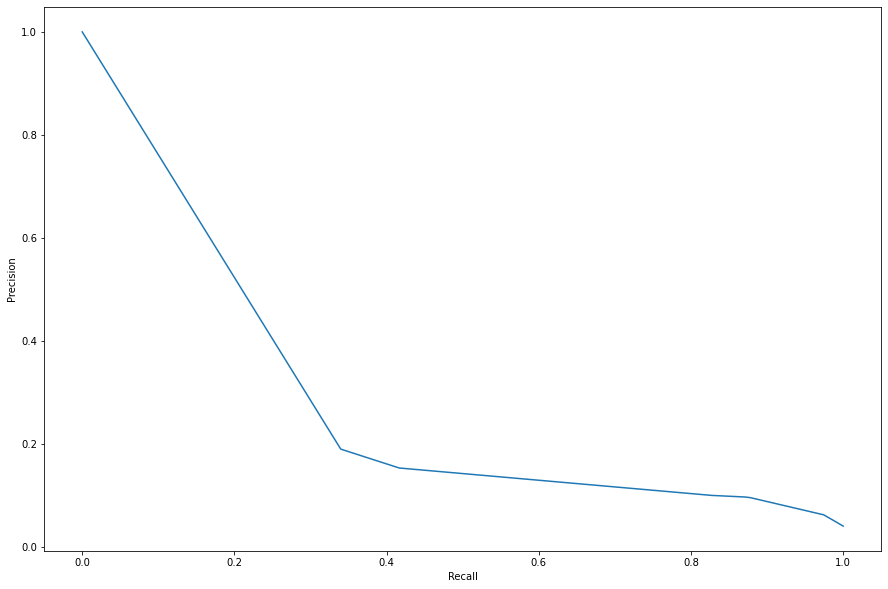

In [95]:
scorer = ['f1', 'recall', 'precision', 'accuracy', 'roc_auc']
refit = 'recall'
cross_val = [0]

for cv_value in cross_val:

    # grid search
    grid_search_clf = grid_search(drzewo, param_drzewo, scorer, refit = refit, cross_val = cv_value)
    grid_search_clf.fit(X_train_scaled, y_train) # w drzewie nie muszą być dane zestandaryzowanne
    best_est = grid_search_clf.best_estimator_
    
    # Zebranie score'ów dla najlepszego klasyfikatora
    slownik_score = {}
    scorer_rank = 'rank_test_' + refit
    rank_min = grid_search_clf.cv_results_[scorer_rank].argmin()
    for sc in scorer:
        scorer_name = 'mean_test_' + sc
        scorer_value = grid_search_clf.cv_results_[scorer_name][rank_min]
        slownik_score[sc] = scorer_value

    #predykcja dla najlepszego estymatora wg recall
    y_pred = best_est.predict(X_train_scaled)
    y_pred_proba = best_est.predict_proba(X_train_scaled)[:,1]


    precision_c, recall_c, thresholds = precision_recall_curve(y_train, y_pred_proba)


    print(f"Liczba kroswalidacji: {cv_value} \n \
Liczba obserwacji w zbiorze treningowym: {sorted(Counter(y_train).items())} \n \
Sprawdzana metryka: {refit} \n \
Najlepsza wartość metryki: {grid_search_clf.best_score_} \n \
Pozostałe score'y: {slownik_score} \n \
\n \
Najlepsze parametry: {grid_search_clf.best_params_} \n \
Macierz kontyngencji:")
    print(confusion_matrix(y_train, y_pred))
    plt.figure(figsize=(15, 10))
    plt.plot(recall_c, precision_c)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    print(classification_report(y_train, y_pred))

In [97]:
#Grid search z oversamplingiem

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter


Liczba kroswalidacji: 0 
 Liczba obserwacji w zbiorze treningowym: [(0, 3771), (1, 3771)] 
 Sprawdzana metryka: recall 
 Najlepsza wartość metryki: 0.9944311135313647 
 Najlepsze parametry: {'criterion': 'entropy', 'max_depth': 3, 'max_features': 4} 
 Macierz kontyngencji:
[[1588 2183]
 [  21 3750]]
              precision    recall  f1-score   support

           0       0.99      0.42      0.59      3771
           1       0.63      0.99      0.77      3771

    accuracy                           0.71      7542
   macro avg       0.81      0.71      0.68      7542
weighted avg       0.81      0.71      0.68      7542

Liczba kroswalidacji: 2 
 Liczba obserwacji w zbiorze treningowym: [(0, 3771), (1, 3771)] 
 Sprawdzana metryka: recall 
 Najlepsza wartość metryki: 0.9944312552916788 
 Najlepsze parametry: {'criterion': 'entropy', 'max_depth': 3, 'max_features': 4} 
 Macierz kontyngencji:
[[1588 2183]
 [  21 3750]]
              precision    recall  f1-score   support

           0    

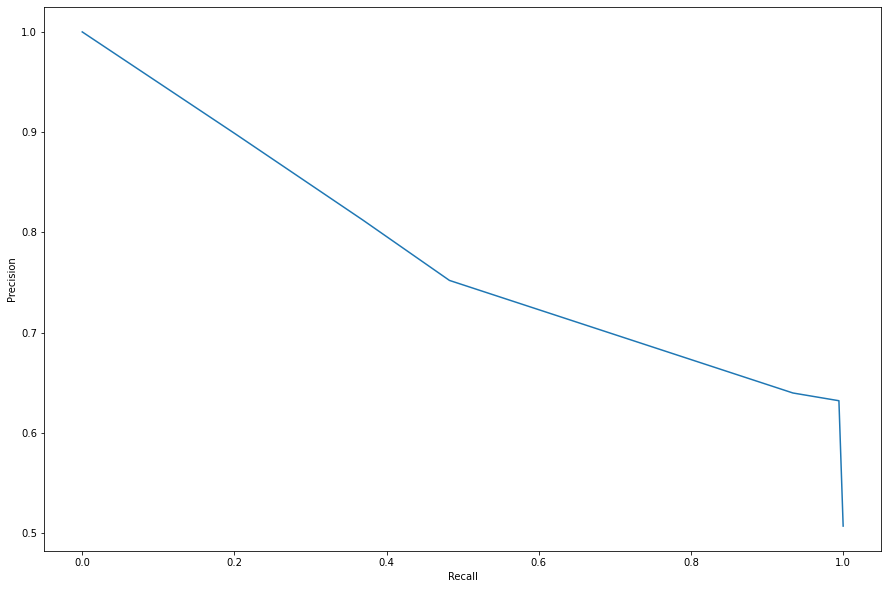

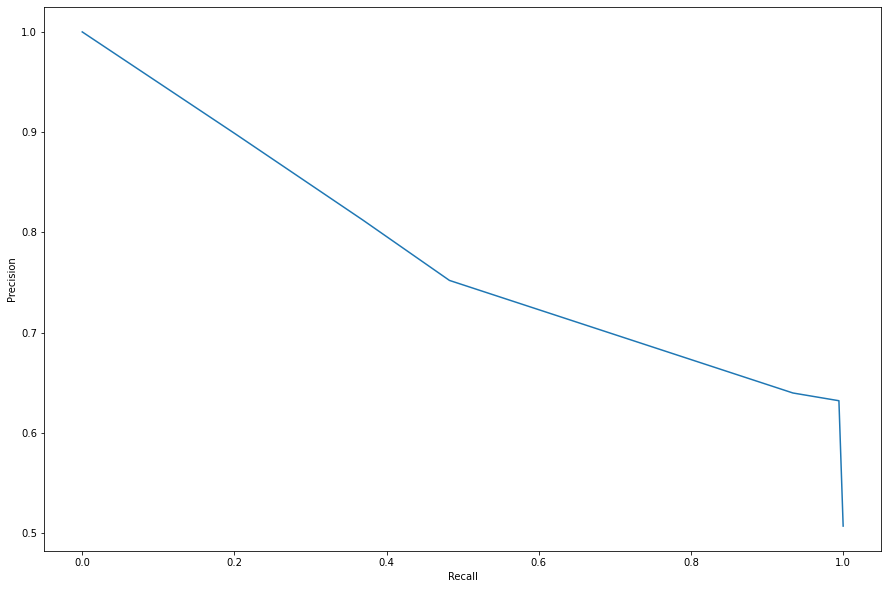

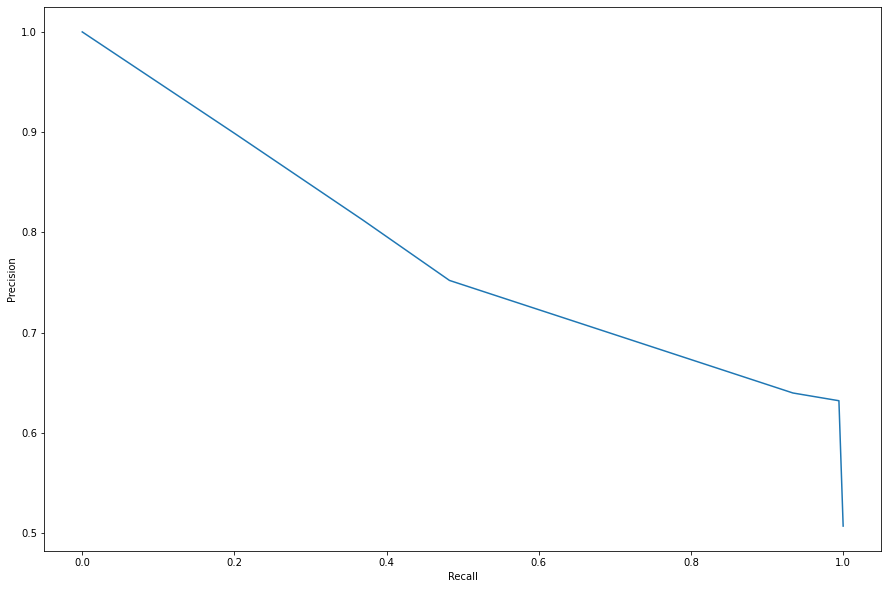

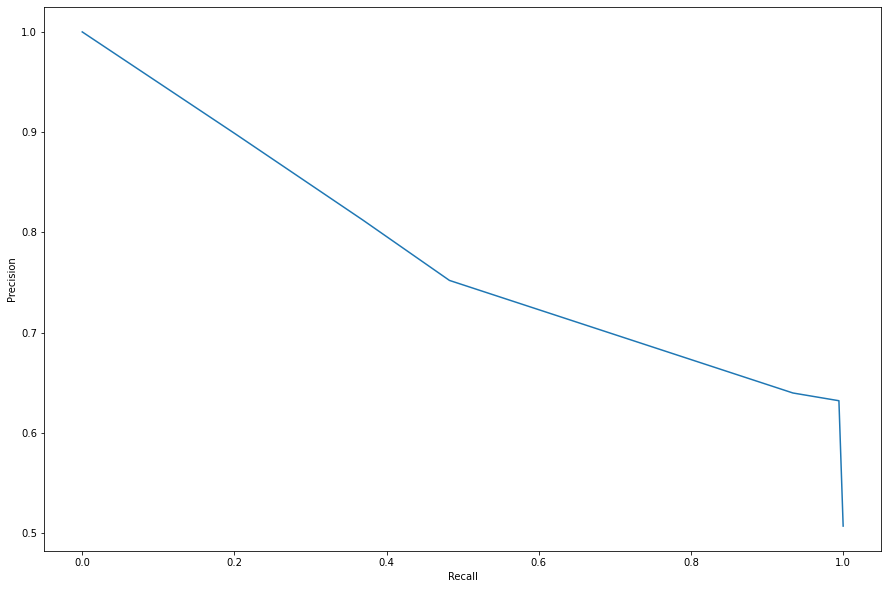

In [108]:
scorer = ['f1', 'recall', 'precision', 'accuracy', 'roc_auc']
refit = 'recall'
cross_val = [0, 2, 5, 10]

for cv_value in cross_val:
    
    #Oversampling
    ros = RandomOverSampler(random_state=42)
    X_train_scaled_ros, y_train_ros= ros.fit_resample(X_train_scaled, y_train)
    
    # grid search
    grid_search_clf = grid_search(drzewo, param_drzewo_samp, scorer, refit = refit, cross_val = cv_value)
    grid_search_clf.fit(X_train_scaled_ros, y_train_ros) # w drzewie nie muszą być dane zestandaryzowanne
    best_est = grid_search_clf.best_estimator_
    
    
    # Zebranie score'ów dla najlepszego klasyfikatora
    slownik_score = {}
    scorer_rank = 'rank_test_' + refit
    rank_min = grid_search_clf.cv_results_[scorer_rank].argmin()
    for sc in scorer:
        scorer_name = 'mean_test_' + sc
        scorer_value = grid_search_clf.cv_results_[scorer_name][rank_min]
        slownik_score[sc] = scorer_value

    #predykcja dla najlepszego estymatora wg recall
    y_pred = best_est.predict(X_train_scaled_ros)
    y_pred_proba = best_est.predict_proba(X_train_scaled_ros)[:,1]


    precision_c, recall_c, thresholds = precision_recall_curve(y_train_ros, y_pred_proba)


    print(f"Liczba kroswalidacji: {cv_value} \n \
Liczba obserwacji w zbiorze treningowym: {sorted(Counter(y_train_ros).items())} \n \
Sprawdzana metryka: {refit} \n \
Najlepsza wartość metryki: {grid_search_clf.best_score_} \n \
Najlepsze parametry: {grid_search_clf.best_params_} \n \
Macierz kontyngencji:")
    print(confusion_matrix(y_train_ros, y_pred))
    plt.figure(figsize=(15, 10))
    plt.plot(recall_c, precision_c)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    print(classification_report(y_train_ros, y_pred))

Liczba kroswalidacji: 0 
 Liczba obserwacji w zbiorze treningowym: [(0, 156), (1, 156)] 
 Sprawdzana metryka: recall 
 Najlepsza wartość metryki: 0.8612903225806452 
 Najlepsze parametry: {'criterion': 'entropy', 'max_depth': 3, 'max_features': 8} 
 Macierz kontyngencji:
[[ 91  65]
 [  7 149]]
              precision    recall  f1-score   support

           0       0.93      0.58      0.72       156
           1       0.70      0.96      0.81       156

    accuracy                           0.77       312
   macro avg       0.81      0.77      0.76       312
weighted avg       0.81      0.77      0.76       312

Liczba kroswalidacji: 2 
 Liczba obserwacji w zbiorze treningowym: [(0, 156), (1, 156)] 
 Sprawdzana metryka: recall 
 Najlepsza wartość metryki: 0.8846153846153846 
 Najlepsze parametry: {'criterion': 'gini', 'max_depth': 3, 'max_features': 5} 
 Macierz kontyngencji:
[[133  23]
 [ 89  67]]
              precision    recall  f1-score   support

           0       0.60      0.

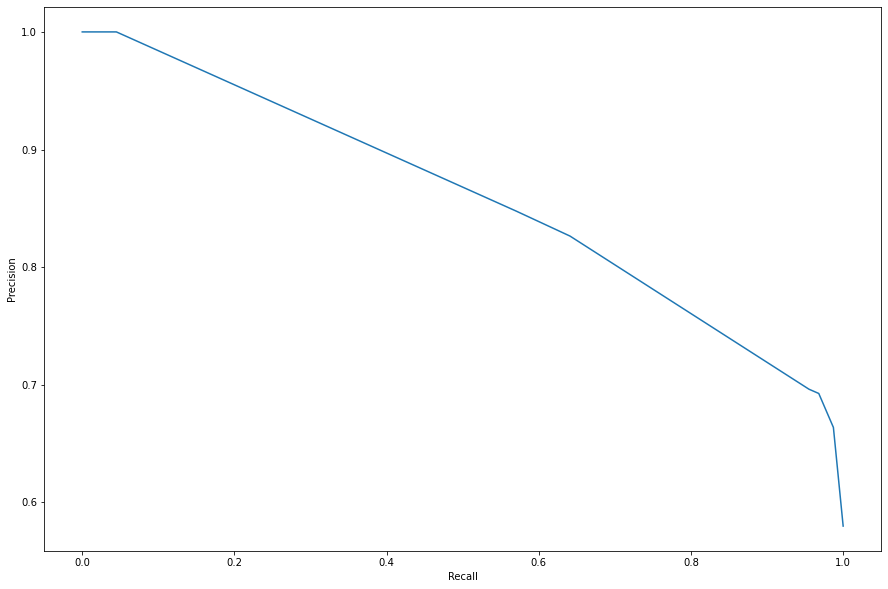

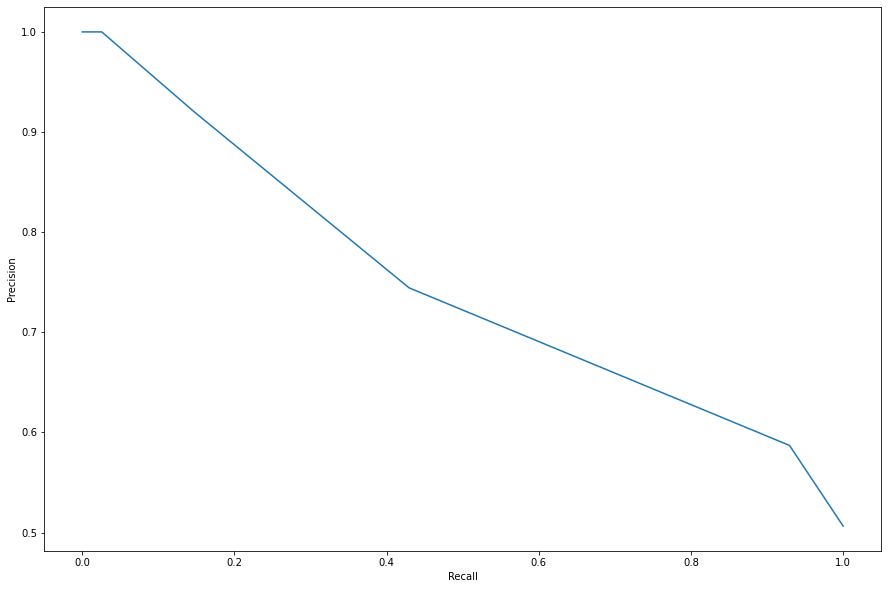

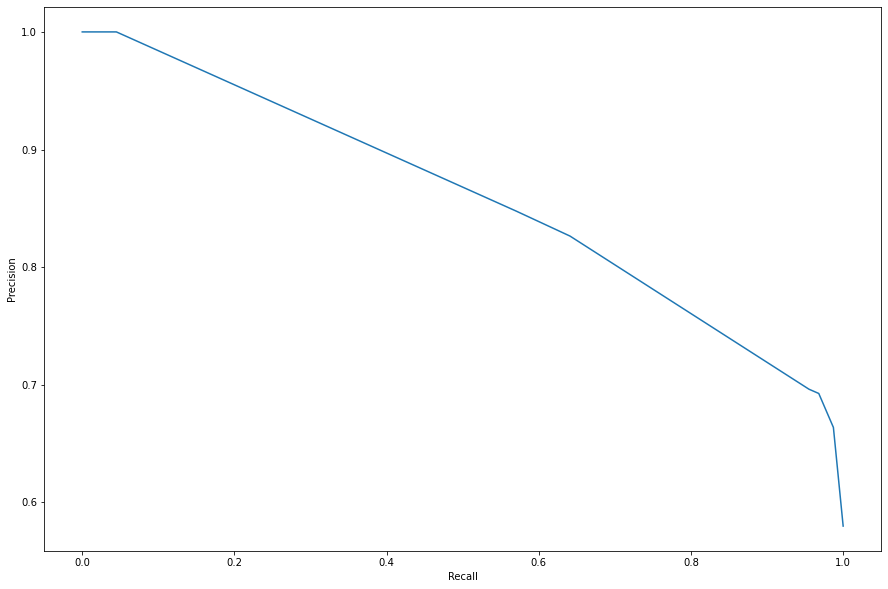

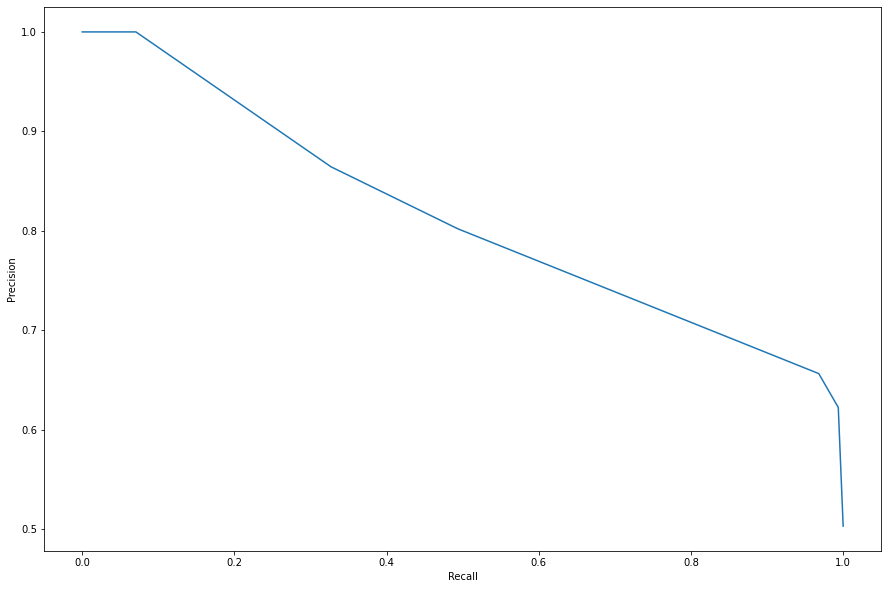

In [109]:
# grid search z undersamplingiem
scorer = ['f1', 'recall', 'precision', 'accuracy', 'roc_auc']
refit = 'recall'
cross_val = [0, 2, 5, 10]

for cv_value in cross_val:
    
    #Oversampling
    rus = RandomUnderSampler(random_state=42)
    X_train_scaled_rus, y_train_rus= rus.fit_resample(X_train_scaled, y_train)
    
    # grid search
    grid_search_clf = grid_search(drzewo, param_drzewo_samp, scorer, refit = refit, cross_val = cv_value)
    grid_search_clf.fit(X_train_scaled_rus, y_train_rus) # w drzewie nie muszą być dane zestandaryzowanne
    best_est = grid_search_clf.best_estimator_
    
    
    # Zebranie score'ów dla najlepszego klasyfikatora
    slownik_score = {}
    scorer_rank = 'rank_test_' + refit
    rank_min = grid_search_clf.cv_results_[scorer_rank].argmin()
    for sc in scorer:
        scorer_name = 'mean_test_' + sc
        scorer_value = grid_search_clf.cv_results_[scorer_name][rank_min]
        slownik_score[sc] = scorer_value

    #predykcja dla najlepszego estymatora wg recall
    y_pred = best_est.predict(X_train_scaled_rus)
    y_pred_proba = best_est.predict_proba(X_train_scaled_rus)[:,1]


    precision_c, recall_c, thresholds = precision_recall_curve(y_train_rus, y_pred_proba)


    print(f"Liczba kroswalidacji: {cv_value} \n \
Liczba obserwacji w zbiorze treningowym: {sorted(Counter(y_train_rus).items())} \n \
Sprawdzana metryka: {refit} \n \
Najlepsza wartość metryki: {grid_search_clf.best_score_} \n \
Najlepsze parametry: {grid_search_clf.best_params_} \n \
Macierz kontyngencji:")
    print(confusion_matrix(y_train_rus, y_pred))
    plt.figure(figsize=(15, 10))
    plt.plot(recall_c, precision_c)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    print(classification_report(y_train_rus, y_pred))

Liczba kroswalidacji: 0 
 Liczba obserwacji w zbiorze treningowym: [(0, 3771), (1, 3771)] 
 Sprawdzana metryka: recall 
 Najlepsza wartość metryki: 0.9790528220352381 
 Najlepsze parametry: {'criterion': 'entropy', 'max_depth': 3, 'max_features': 5} 
 Macierz kontyngencji:
[[1316 2455]
 [  78 3693]]
              precision    recall  f1-score   support

           0       0.94      0.35      0.51      3771
           1       0.60      0.98      0.74      3771

    accuracy                           0.66      7542
   macro avg       0.77      0.66      0.63      7542
weighted avg       0.77      0.66      0.63      7542

Liczba kroswalidacji: 2 
 Liczba obserwacji w zbiorze treningowym: [(0, 3771), (1, 3771)] 
 Sprawdzana metryka: recall 
 Najlepsza wartość metryki: 0.9790491714743004 
 Najlepsze parametry: {'criterion': 'entropy', 'max_depth': 3, 'max_features': 5} 
 Macierz kontyngencji:
[[1316 2455]
 [  78 3693]]
              precision    recall  f1-score   support

           0    

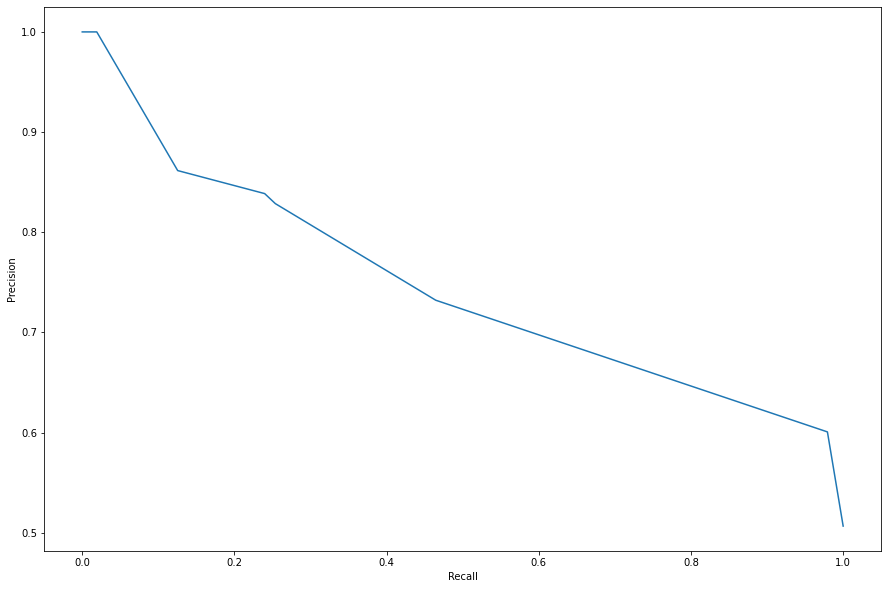

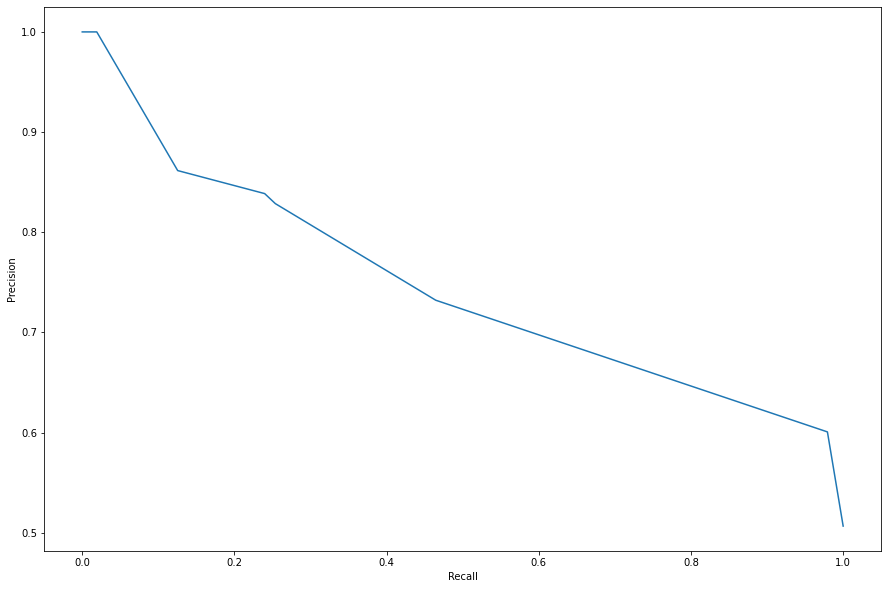

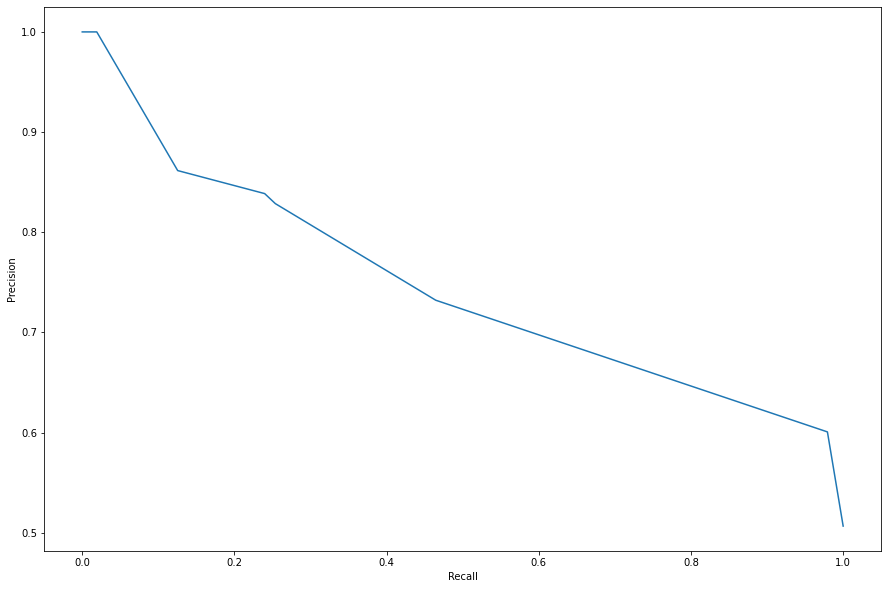

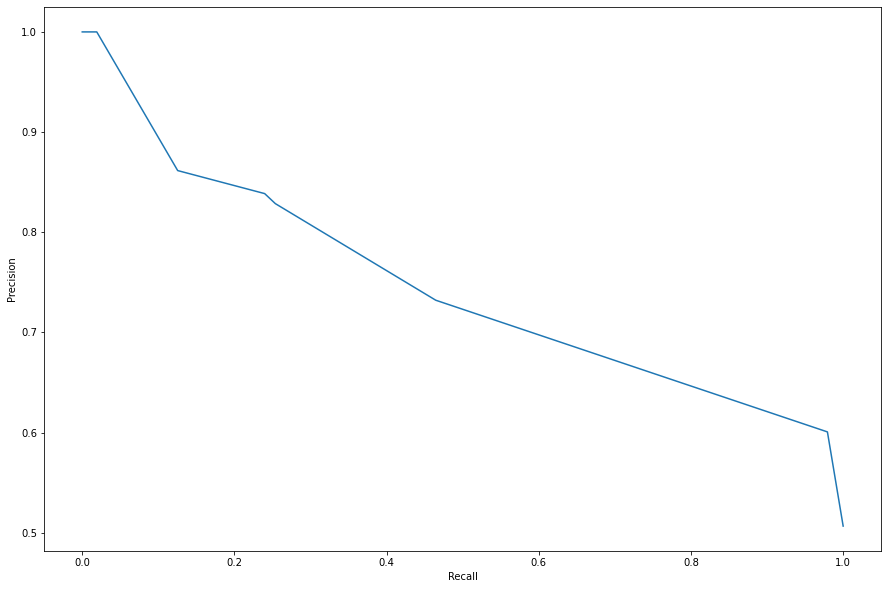

In [111]:
# grid search z SMOTE
scorer = ['f1', 'recall', 'precision', 'accuracy', 'roc_auc']
refit = 'recall'
cross_val = [0, 2, 5, 10]

for cv_value in cross_val:
    
    #Oversampling
    smt = SMOTE(random_state=42)
    X_train_scaled_smt, y_train_smt= smt.fit_resample(X_train_scaled, y_train)
    
    # grid search
    grid_search_clf = grid_search(drzewo, param_drzewo_samp, scorer, refit = refit, cross_val = cv_value)
    grid_search_clf.fit(X_train_scaled_smt, y_train_smt) # w drzewie nie muszą być dane zestandaryzowanne
    best_est = grid_search_clf.best_estimator_
    
    
    # Zebranie score'ów dla najlepszego klasyfikatora
    slownik_score = {}
    scorer_rank = 'rank_test_' + refit
    rank_min = grid_search_clf.cv_results_[scorer_rank].argmin()
    for sc in scorer:
        scorer_name = 'mean_test_' + sc
        scorer_value = grid_search_clf.cv_results_[scorer_name][rank_min]
        slownik_score[sc] = scorer_value

    #predykcja dla najlepszego estymatora wg recall
    y_pred = best_est.predict(X_train_scaled_smt)
    y_pred_proba = best_est.predict_proba(X_train_scaled_smt)[:,1]


    precision_c, recall_c, thresholds = precision_recall_curve(y_train_smt, y_pred_proba)


    print(f"Liczba kroswalidacji: {cv_value} \n \
Liczba obserwacji w zbiorze treningowym: {sorted(Counter(y_train_smt).items())} \n \
Sprawdzana metryka: {refit} \n \
Najlepsza wartość metryki: {grid_search_clf.best_score_} \n \
Najlepsze parametry: {grid_search_clf.best_params_} \n \
Macierz kontyngencji:")
    print(confusion_matrix(y_train_smt, y_pred))
    plt.figure(figsize=(15, 10))
    plt.plot(recall_c, precision_c)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    print(classification_report(y_train_smt, y_pred))

## Lasy

In [113]:
las =RandomForestClassifier(random_state=42)

In [117]:
param_las = {"max_depth": [3, 4, 5, 6, 7],
                "criterion": ['entropy', 'gini'],
              "max_features": list(range(3,10)),
                'n_estimators': [10, 50]
             }

In [114]:
RandomForestClassifier?

Liczba kroswalidacji: 0 
 Liczba obserwacji w zbiorze treningowym: [(0, 3771), (1, 3771)] 
 Sprawdzana metryka: recall 
 Najlepsza wartość metryki: 0.9708289563827357 
 Najlepsze parametry: {'criterion': 'gini', 'max_depth': 7, 'max_features': 9, 'n_estimators': 50} 
 Macierz kontyngencji:
[[3290  481]
 [  74 3697]]
              precision    recall  f1-score   support

           0       0.98      0.87      0.92      3771
           1       0.88      0.98      0.93      3771

    accuracy                           0.93      7542
   macro avg       0.93      0.93      0.93      7542
weighted avg       0.93      0.93      0.93      7542

Liczba kroswalidacji: 2 
 Liczba obserwacji w zbiorze treningowym: [(0, 3771), (1, 3771)] 
 Sprawdzana metryka: recall 
 Najlepsza wartość metryki: 0.9573039934066738 
 Najlepsze parametry: {'criterion': 'gini', 'max_depth': 7, 'max_features': 9, 'n_estimators': 50} 
 Macierz kontyngencji:
[[3290  481]
 [  74 3697]]
              precision    recall  f1

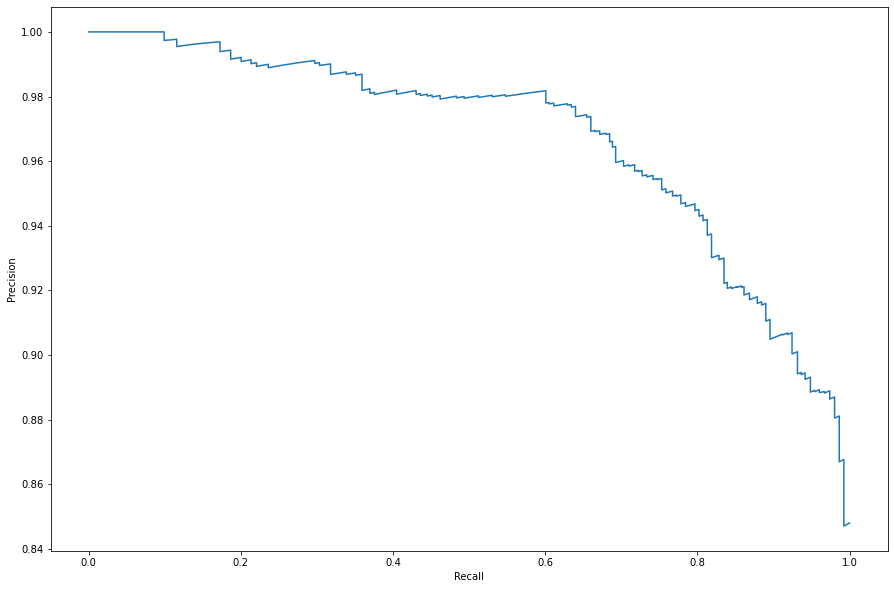

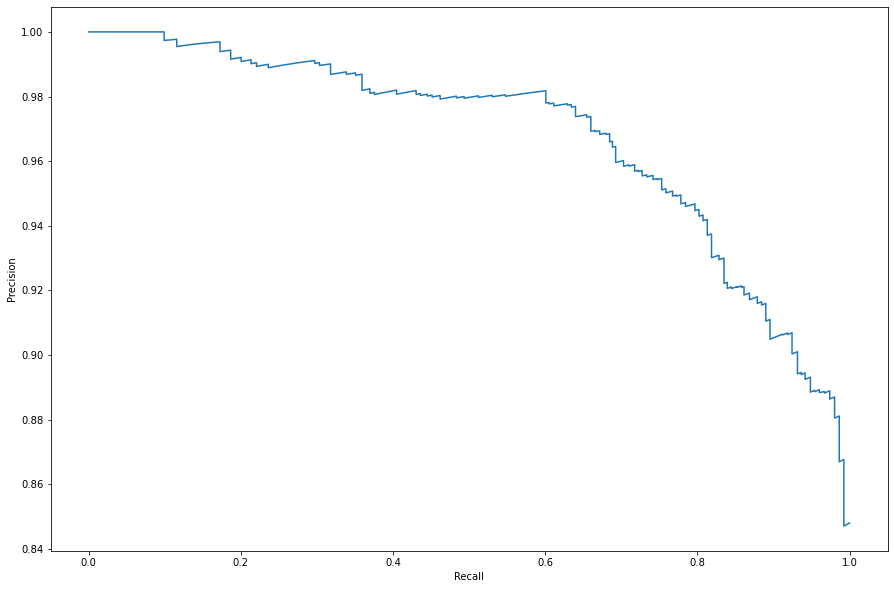

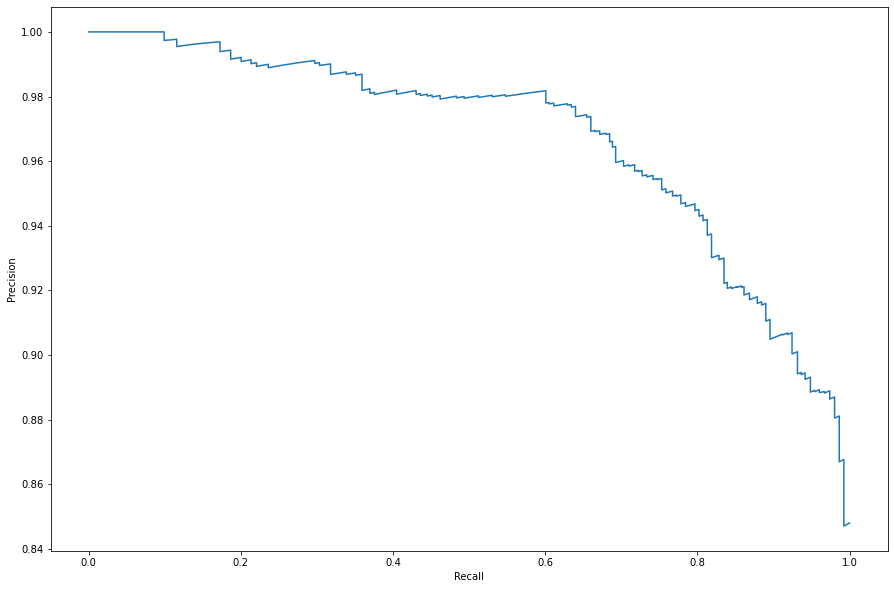

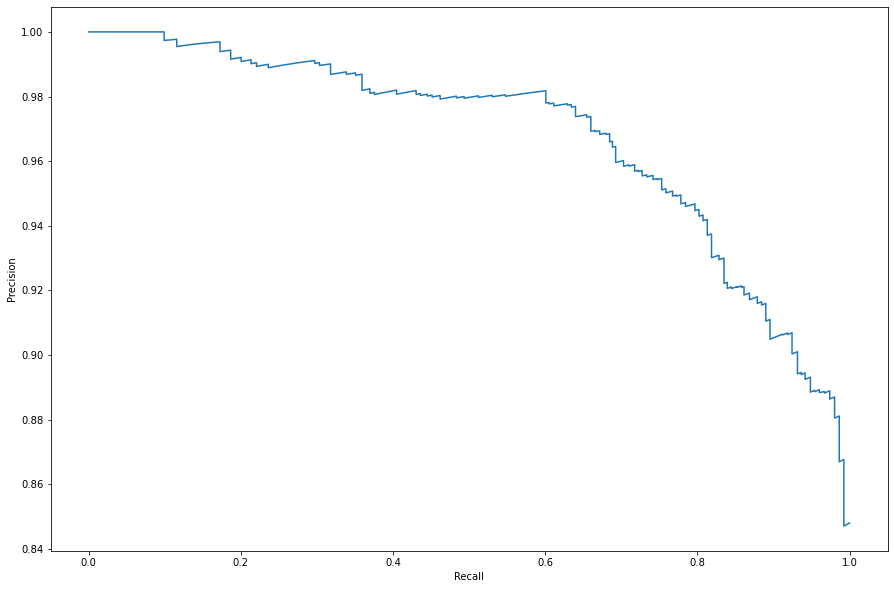

In [116]:
scorer = ['f1', 'recall', 'precision', 'accuracy', 'roc_auc']
refit = 'recall'
cross_val = [0, 2, 5, 10]

for cv_value in cross_val:
    
    #Oversampling
    ros = RandomOverSampler(random_state=42)
    X_train_scaled_ros, y_train_ros= ros.fit_resample(X_train_scaled, y_train)
    
    # grid search
    grid_search_clf = grid_search(las, param_las, scorer, refit = refit, cross_val = cv_value)
    grid_search_clf.fit(X_train_scaled_ros, y_train_ros) # w drzewie nie muszą być dane zestandaryzowanne
    best_est = grid_search_clf.best_estimator_
    
    
    # Zebranie score'ów dla najlepszego klasyfikatora
    slownik_score = {}
    scorer_rank = 'rank_test_' + refit
    rank_min = grid_search_clf.cv_results_[scorer_rank].argmin()
    for sc in scorer:
        scorer_name = 'mean_test_' + sc
        scorer_value = grid_search_clf.cv_results_[scorer_name][rank_min]
        slownik_score[sc] = scorer_value

    #predykcja dla najlepszego estymatora wg recall
    y_pred = best_est.predict(X_train_scaled_ros)
    y_pred_proba = best_est.predict_proba(X_train_scaled_ros)[:,1]


    precision_c, recall_c, thresholds = precision_recall_curve(y_train_ros, y_pred_proba)


    print(f"Liczba kroswalidacji: {cv_value} \n \
Liczba obserwacji w zbiorze treningowym: {sorted(Counter(y_train_ros).items())} \n \
Sprawdzana metryka: {refit} \n \
Najlepsza wartość metryki: {grid_search_clf.best_score_} \n \
Najlepsze parametry: {grid_search_clf.best_params_} \n \
Macierz kontyngencji:")
    print(confusion_matrix(y_train_ros, y_pred))
    plt.figure(figsize=(15, 10))
    plt.plot(recall_c, precision_c)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    print(classification_report(y_train_ros, y_pred))

Liczba kroswalidacji: 0 
 Liczba obserwacji w zbiorze treningowym: [(0, 156), (1, 156)] 
 Sprawdzana metryka: recall 
 Najlepsza wartość metryki: 0.8409274193548388 
 Najlepsze parametry: {'criterion': 'entropy', 'max_depth': 4, 'max_features': 9, 'n_estimators': 10} 
 Macierz kontyngencji:
[[116  40]
 [ 16 140]]
              precision    recall  f1-score   support

           0       0.88      0.74      0.81       156
           1       0.78      0.90      0.83       156

    accuracy                           0.82       312
   macro avg       0.83      0.82      0.82       312
weighted avg       0.83      0.82      0.82       312

Liczba kroswalidacji: 2 
 Liczba obserwacji w zbiorze treningowym: [(0, 156), (1, 156)] 
 Sprawdzana metryka: recall 
 Najlepsza wartość metryki: 0.8653846153846154 
 Najlepsze parametry: {'criterion': 'entropy', 'max_depth': 3, 'max_features': 7, 'n_estimators': 10} 
 Macierz kontyngencji:
[[116  40]
 [ 20 136]]
              precision    recall  f1-score

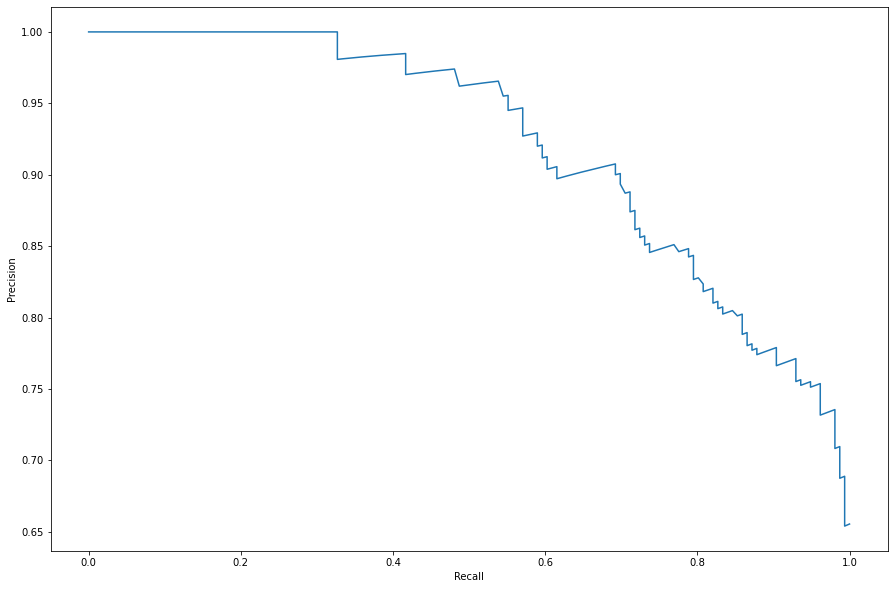

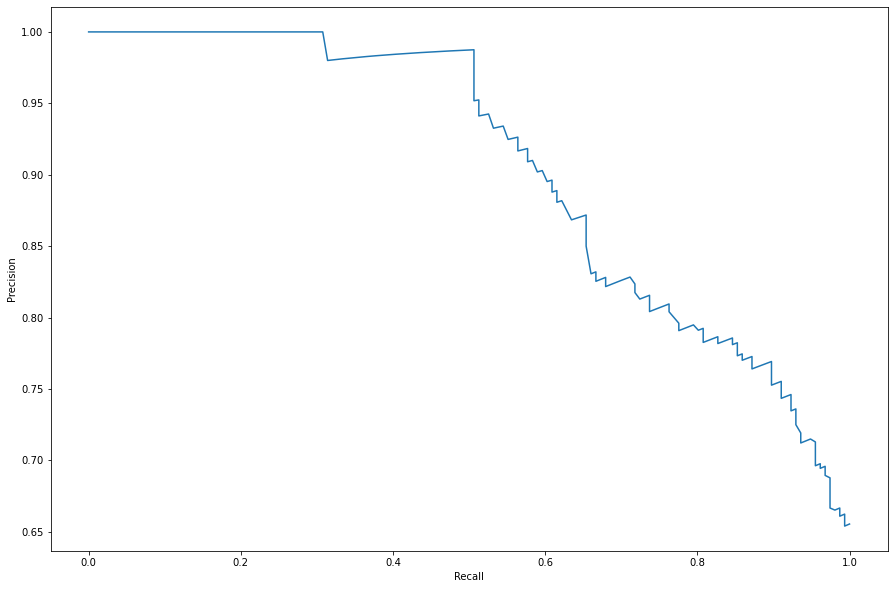

In [118]:
# grid search z undersamplingiem
scorer = ['f1', 'recall', 'precision', 'accuracy', 'roc_auc']
refit = 'recall'
cross_val = [0, 2]

for cv_value in cross_val:
    
    #Oversampling
    rus = RandomUnderSampler(random_state=42)
    X_train_scaled_rus, y_train_rus= rus.fit_resample(X_train_scaled, y_train)
    
    # grid search
    grid_search_clf = grid_search(las, param_las, scorer, refit = refit, cross_val = cv_value)
    grid_search_clf.fit(X_train_scaled_rus, y_train_rus) # w drzewie nie muszą być dane zestandaryzowanne
    best_est = grid_search_clf.best_estimator_
    
    
    # Zebranie score'ów dla najlepszego klasyfikatora
    slownik_score = {}
    scorer_rank = 'rank_test_' + refit
    rank_min = grid_search_clf.cv_results_[scorer_rank].argmin()
    for sc in scorer:
        scorer_name = 'mean_test_' + sc
        scorer_value = grid_search_clf.cv_results_[scorer_name][rank_min]
        slownik_score[sc] = scorer_value

    #predykcja dla najlepszego estymatora wg recall
    y_pred = best_est.predict(X_train_scaled_rus)
    y_pred_proba = best_est.predict_proba(X_train_scaled_rus)[:,1]


    precision_c, recall_c, thresholds = precision_recall_curve(y_train_rus, y_pred_proba)


    print(f"Liczba kroswalidacji: {cv_value} \n \
Liczba obserwacji w zbiorze treningowym: {sorted(Counter(y_train_rus).items())} \n \
Sprawdzana metryka: {refit} \n \
Najlepsza wartość metryki: {grid_search_clf.best_score_} \n \
Najlepsze parametry: {grid_search_clf.best_params_} \n \
Macierz kontyngencji:")
    print(confusion_matrix(y_train_rus, y_pred))
    plt.figure(figsize=(15, 10))
    plt.plot(recall_c, precision_c)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    print(classification_report(y_train_rus, y_pred))

Liczba kroswalidacji: 0 
 Liczba obserwacji w zbiorze treningowym: [(0, 3771), (1, 3771)] 
 Sprawdzana metryka: recall 
 Najlepsza wartość metryki: 0.9493495178035027 
 Najlepsze parametry: {'criterion': 'entropy', 'max_depth': 6, 'max_features': 4, 'n_estimators': 50} 
 Macierz kontyngencji:
[[2952  819]
 [ 162 3609]]
              precision    recall  f1-score   support

           0       0.95      0.78      0.86      3771
           1       0.82      0.96      0.88      3771

    accuracy                           0.87      7542
   macro avg       0.88      0.87      0.87      7542
weighted avg       0.88      0.87      0.87      7542

Liczba kroswalidacji: 2 
 Liczba obserwacji w zbiorze treningowym: [(0, 3771), (1, 3771)] 
 Sprawdzana metryka: recall 
 Najlepsza wartość metryki: 0.9512034789359542 
 Najlepsze parametry: {'criterion': 'entropy', 'max_depth': 4, 'max_features': 4, 'n_estimators': 50} 
 Macierz kontyngencji:
[[2656 1115]
 [ 207 3564]]
              precision    reca

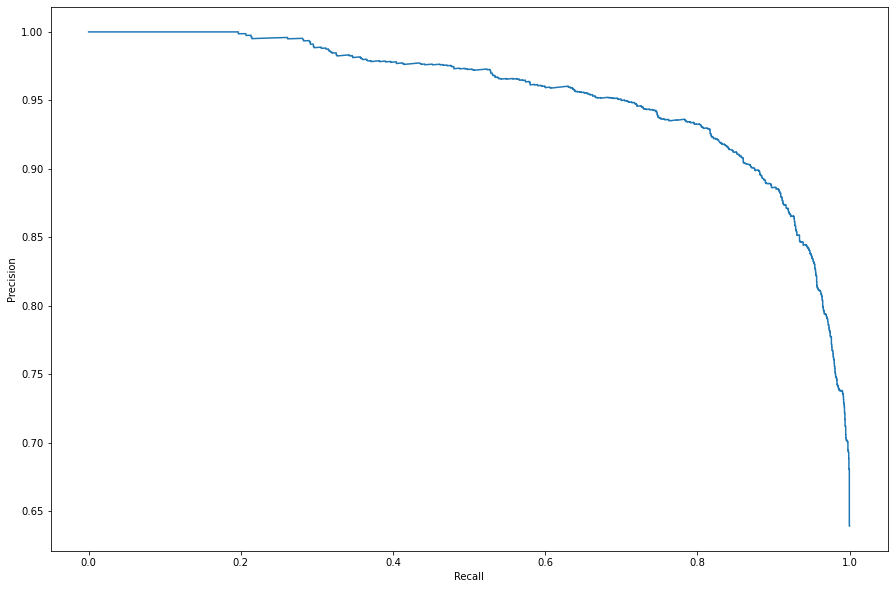

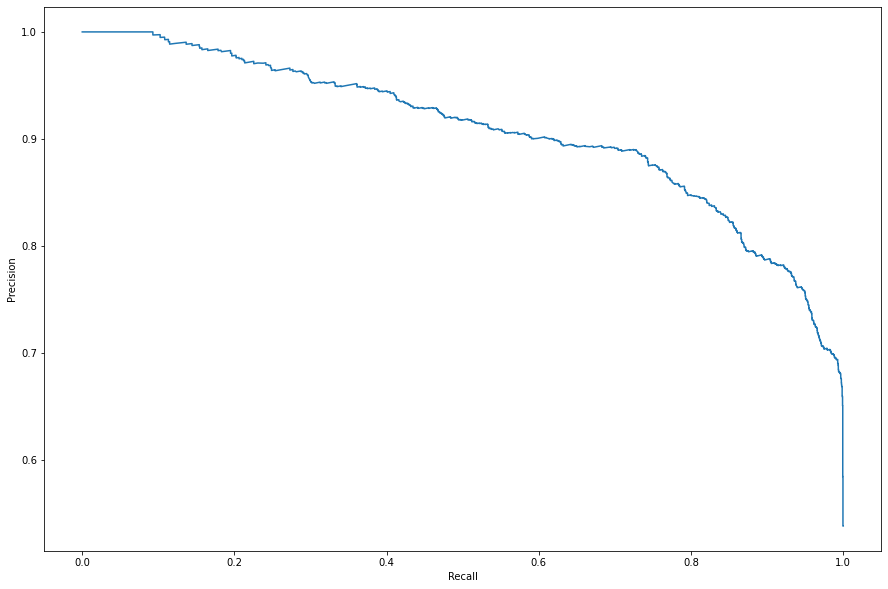

In [119]:
# grid search z SMOTE
scorer = ['f1', 'recall', 'precision', 'accuracy', 'roc_auc']
refit = 'recall'
cross_val = [0, 2]

for cv_value in cross_val:
    
    #Oversampling
    smt = SMOTE(random_state=42)
    X_train_scaled_smt, y_train_smt= smt.fit_resample(X_train_scaled, y_train)
    
    # grid search
    grid_search_clf = grid_search(las, param_las, scorer, refit = refit, cross_val = cv_value)
    grid_search_clf.fit(X_train_scaled_smt, y_train_smt) # w drzewie nie muszą być dane zestandaryzowanne
    best_est = grid_search_clf.best_estimator_
    
    
    # Zebranie score'ów dla najlepszego klasyfikatora
    slownik_score = {}
    scorer_rank = 'rank_test_' + refit
    rank_min = grid_search_clf.cv_results_[scorer_rank].argmin()
    for sc in scorer:
        scorer_name = 'mean_test_' + sc
        scorer_value = grid_search_clf.cv_results_[scorer_name][rank_min]
        slownik_score[sc] = scorer_value

    #predykcja dla najlepszego estymatora wg recall
    y_pred = best_est.predict(X_train_scaled_smt)
    y_pred_proba = best_est.predict_proba(X_train_scaled_smt)[:,1]


    precision_c, recall_c, thresholds = precision_recall_curve(y_train_smt, y_pred_proba)


    print(f"Liczba kroswalidacji: {cv_value} \n \
Liczba obserwacji w zbiorze treningowym: {sorted(Counter(y_train_smt).items())} \n \
Sprawdzana metryka: {refit} \n \
Najlepsza wartość metryki: {grid_search_clf.best_score_} \n \
Najlepsze parametry: {grid_search_clf.best_params_} \n \
Macierz kontyngencji:")
    print(confusion_matrix(y_train_smt, y_pred))
    plt.figure(figsize=(15, 10))
    plt.plot(recall_c, precision_c)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    print(classification_report(y_train_smt, y_pred))

Liczba kroswalidacji: 0 
 Liczba obserwacji w zbiorze treningowym: [(0, 3771), (1, 3771)] 
 Sprawdzana metryka: f1 
 Najlepsza wartość metryki: 0.9150267975084321 
 Najlepsze parametry: {'criterion': 'gini', 'max_depth': 7, 'max_features': 9, 'n_estimators': 50} 
 Macierz kontyngencji:
[[3290  481]
 [  74 3697]]
              precision    recall  f1-score   support

           0       0.98      0.87      0.92      3771
           1       0.88      0.98      0.93      3771

    accuracy                           0.93      7542
   macro avg       0.93      0.93      0.93      7542
weighted avg       0.93      0.93      0.93      7542

Liczba kroswalidacji: 2 
 Liczba obserwacji w zbiorze treningowym: [(0, 3771), (1, 3771)] 
 Sprawdzana metryka: f1 
 Najlepsza wartość metryki: 0.9055464629932715 
 Najlepsze parametry: {'criterion': 'gini', 'max_depth': 7, 'max_features': 9, 'n_estimators': 50} 
 Macierz kontyngencji:
[[3290  481]
 [  74 3697]]
              precision    recall  f1-score  

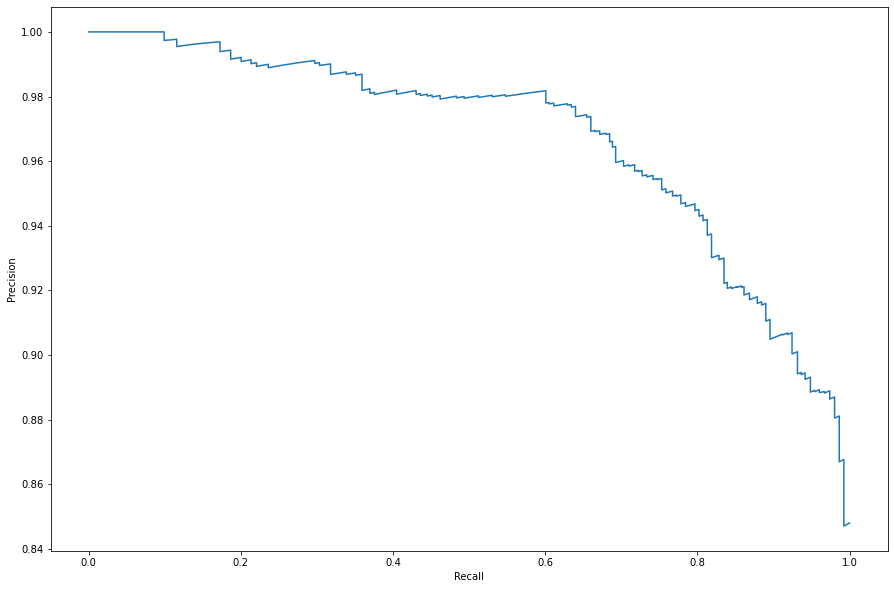

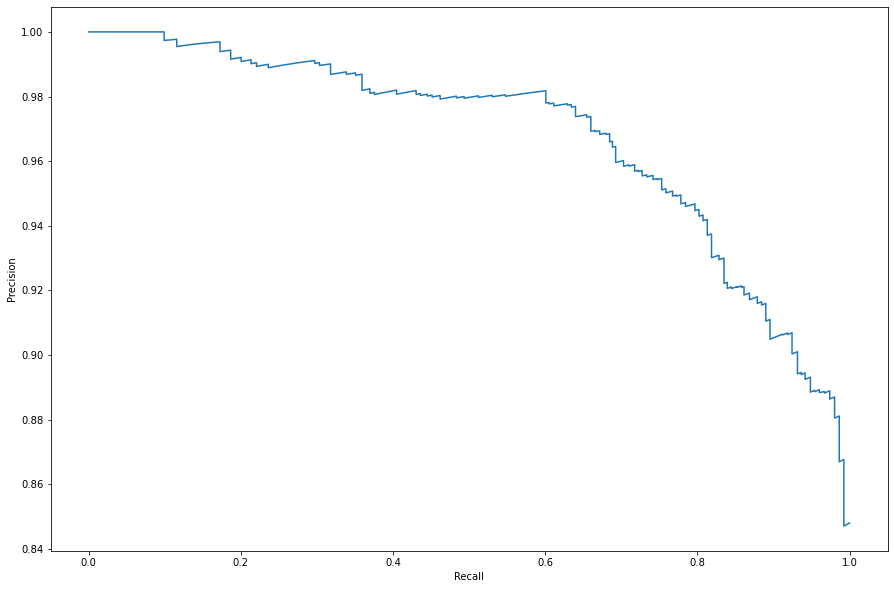

In [120]:
scorer = ['f1', 'recall', 'precision', 'accuracy', 'roc_auc']
refit = 'f1'
cross_val = [0, 2]

for cv_value in cross_val:
    
    #Oversampling
    ros = RandomOverSampler(random_state=42)
    X_train_scaled_ros, y_train_ros= ros.fit_resample(X_train_scaled, y_train)
    
    # grid search
    grid_search_clf = grid_search(las, param_las, scorer, refit = refit, cross_val = cv_value)
    grid_search_clf.fit(X_train_scaled_ros, y_train_ros) # w drzewie nie muszą być dane zestandaryzowanne
    best_est = grid_search_clf.best_estimator_
    
    
    # Zebranie score'ów dla najlepszego klasyfikatora
    slownik_score = {}
    scorer_rank = 'rank_test_' + refit
    rank_min = grid_search_clf.cv_results_[scorer_rank].argmin()
    for sc in scorer:
        scorer_name = 'mean_test_' + sc
        scorer_value = grid_search_clf.cv_results_[scorer_name][rank_min]
        slownik_score[sc] = scorer_value

    #predykcja dla najlepszego estymatora wg recall
    y_pred = best_est.predict(X_train_scaled_ros)
    y_pred_proba = best_est.predict_proba(X_train_scaled_ros)[:,1]


    precision_c, recall_c, thresholds = precision_recall_curve(y_train_ros, y_pred_proba)


    print(f"Liczba kroswalidacji: {cv_value} \n \
Liczba obserwacji w zbiorze treningowym: {sorted(Counter(y_train_ros).items())} \n \
Sprawdzana metryka: {refit} \n \
Najlepsza wartość metryki: {grid_search_clf.best_score_} \n \
Najlepsze parametry: {grid_search_clf.best_params_} \n \
Macierz kontyngencji:")
    print(confusion_matrix(y_train_ros, y_pred))
    plt.figure(figsize=(15, 10))
    plt.plot(recall_c, precision_c)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    print(classification_report(y_train_ros, y_pred))

# xgboost

In [164]:
param_xgb = {"max_depth": [3, 4, 5, 6, 7],
                'n_estimators': [10, 50],
             'booster': ['gbtree', 'gblinear', 'dart'],
                 'learning_rate': [0.3, 0.5, 0.8]
             }

In [166]:
xgb_cl = xgb.XGBClassifier(eval_metric='aucpr', random_state=42)

In [173]:
xgb.set_config(verbosity=0)

F:\Anaconda\envs\projekt_python\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Anaconda\envs\projekt_python\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Anaconda\envs\projekt_python\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Anaconda\envs\projekt_python\lib\site-packages\sklearn\metrics\_classification.py:1318: Undefi

F:\Anaconda\envs\projekt_python\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Anaconda\envs\projekt_python\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Anaconda\envs\projekt_python\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Anaconda\envs\projekt_python\lib\site-packages\sklearn\metrics\_classification.py:1318: Undefi

F:\Anaconda\envs\projekt_python\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Anaconda\envs\projekt_python\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Anaconda\envs\projekt_python\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Anaconda\envs\projekt_python\lib\site-packages\sklearn\metrics\_classification.py:1318: Undefi

F:\Anaconda\envs\projekt_python\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Anaconda\envs\projekt_python\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Anaconda\envs\projekt_python\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Anaconda\envs\projekt_python\lib\site-packages\sklearn\metrics\_classification.py:1318: Undefi

Liczba kroswalidacji: 0 
 Liczba obserwacji w zbiorze treningowym: [(0, 3771), (1, 156)] 
 Sprawdzana metryka: recall 
 Najlepsza wartość metryki: 0.06431451612903225 
 Pozostałe score'y: {'f1': 0.10034047442442225, 'recall': 0.06431451612903225, 'precision': 0.22984848484848489, 'accuracy': 0.9536545598936808, 'roc_auc': 0.7811080429406762} 
 
 Najlepsze parametry: {'booster': 'gbtree', 'learning_rate': 0.8, 'max_depth': 3, 'n_estimators': 50} 
 Macierz kontyngencji:
[[3767    4]
 [ 101   55]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      3771
           1       0.93      0.35      0.51       156

    accuracy                           0.97      3927
   macro avg       0.95      0.68      0.75      3927
weighted avg       0.97      0.97      0.97      3927



F:\Anaconda\envs\projekt_python\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Anaconda\envs\projekt_python\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Anaconda\envs\projekt_python\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Anaconda\envs\projekt_python\lib\site-packages\sklearn\metrics\_classification.py:1318: Undefi

Liczba kroswalidacji: 2 
 Liczba obserwacji w zbiorze treningowym: [(0, 3771), (1, 156)] 
 Sprawdzana metryka: recall 
 Najlepsza wartość metryki: 0.05128205128205128 
 Pozostałe score'y: {'f1': 0.07393262828045435, 'recall': 0.05128205128205128, 'precision': 0.14177489177489178, 'accuracy': 0.9523804953762737, 'roc_auc': 0.7697263884293962} 
 
 Najlepsze parametry: {'booster': 'gbtree', 'learning_rate': 0.8, 'max_depth': 7, 'n_estimators': 10} 
 Macierz kontyngencji:
[[3770    1]
 [  74   82]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3771
           1       0.99      0.53      0.69       156

    accuracy                           0.98      3927
   macro avg       0.98      0.76      0.84      3927
weighted avg       0.98      0.98      0.98      3927



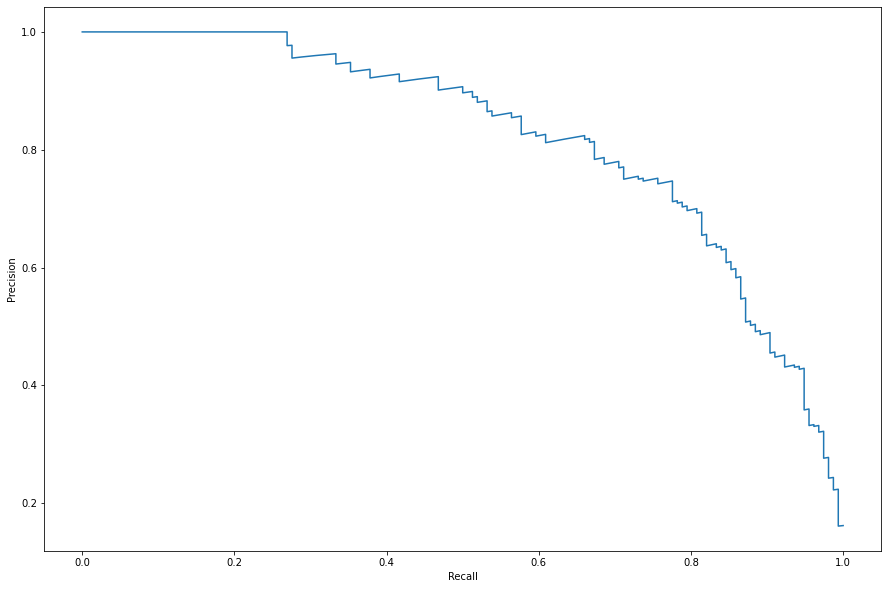

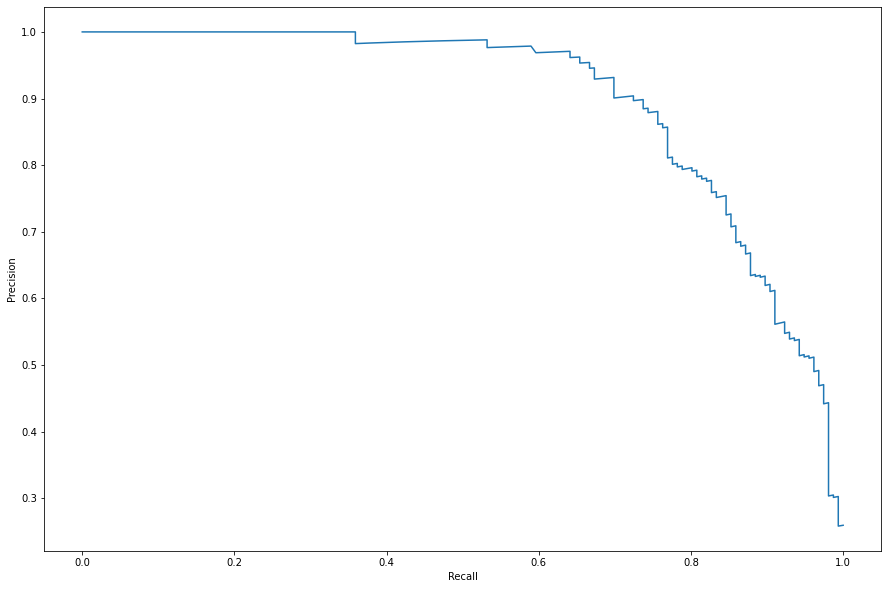

In [175]:
scorer = ['f1', 'recall', 'precision', 'accuracy', 'roc_auc']
refit = 'recall'
cross_val = [0, 2]

for cv_value in cross_val:

    # grid search
    grid_search_clf = grid_search(xgb_cl, param_xgb, scorer, refit = refit, cross_val = cv_value)
    grid_search_clf.fit(X_train_scaled, y_train) # w drzewie nie muszą być dane zestandaryzowanne
    best_est = grid_search_clf.best_estimator_
    
    # Zebranie score'ów dla najlepszego klasyfikatora
    slownik_score = {}
    scorer_rank = 'rank_test_' + refit
    rank_min = grid_search_clf.cv_results_[scorer_rank].argmin()
    for sc in scorer:
        scorer_name = 'mean_test_' + sc
        scorer_value = grid_search_clf.cv_results_[scorer_name][rank_min]
        slownik_score[sc] = scorer_value

    #predykcja dla najlepszego estymatora wg recall
    y_pred = best_est.predict(X_train_scaled)
    y_pred_proba = best_est.predict_proba(X_train_scaled)[:,1]


    precision_c, recall_c, thresholds = precision_recall_curve(y_train, y_pred_proba)


    print(f"Liczba kroswalidacji: {cv_value} \n \
Liczba obserwacji w zbiorze treningowym: {sorted(Counter(y_train).items())} \n \
Sprawdzana metryka: {refit} \n \
Najlepsza wartość metryki: {grid_search_clf.best_score_} \n \
Pozostałe score'y: {slownik_score} \n \
\n \
Najlepsze parametry: {grid_search_clf.best_params_} \n \
Macierz kontyngencji:")
    print(confusion_matrix(y_train, y_pred))
    plt.figure(figsize=(15, 10))
    plt.plot(recall_c, precision_c)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    print(classification_report(y_train, y_pred))

Liczba kroswalidacji: 0 
 Liczba obserwacji w zbiorze treningowym: [(0, 3771), (1, 3771)] 
 Sprawdzana metryka: recall 
 Najlepsza wartość metryki: 1.0 
 Najlepsze parametry: {'booster': 'gbtree', 'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 50} 
 Macierz kontyngencji:
[[3623  148]
 [   0 3771]]
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      3771
           1       0.96      1.00      0.98      3771

    accuracy                           0.98      7542
   macro avg       0.98      0.98      0.98      7542
weighted avg       0.98      0.98      0.98      7542

Liczba kroswalidacji: 2 
 Liczba obserwacji w zbiorze treningowym: [(0, 3771), (1, 3771)] 
 Sprawdzana metryka: recall 
 Najlepsza wartość metryki: 1.0 
 Najlepsze parametry: {'booster': 'gbtree', 'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 50} 
 Macierz kontyngencji:
[[3623  148]
 [   0 3771]]
              precision    recall  f1-score   support

      

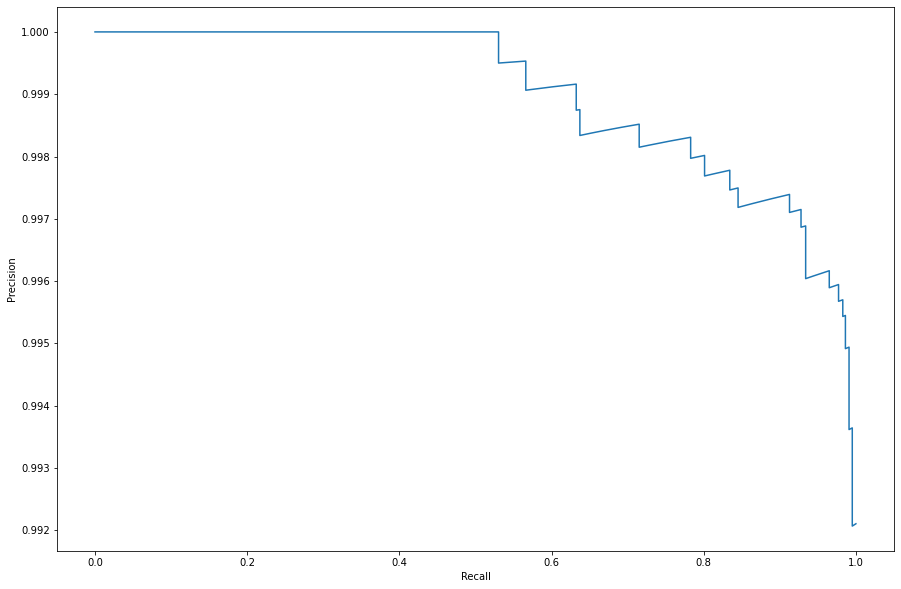

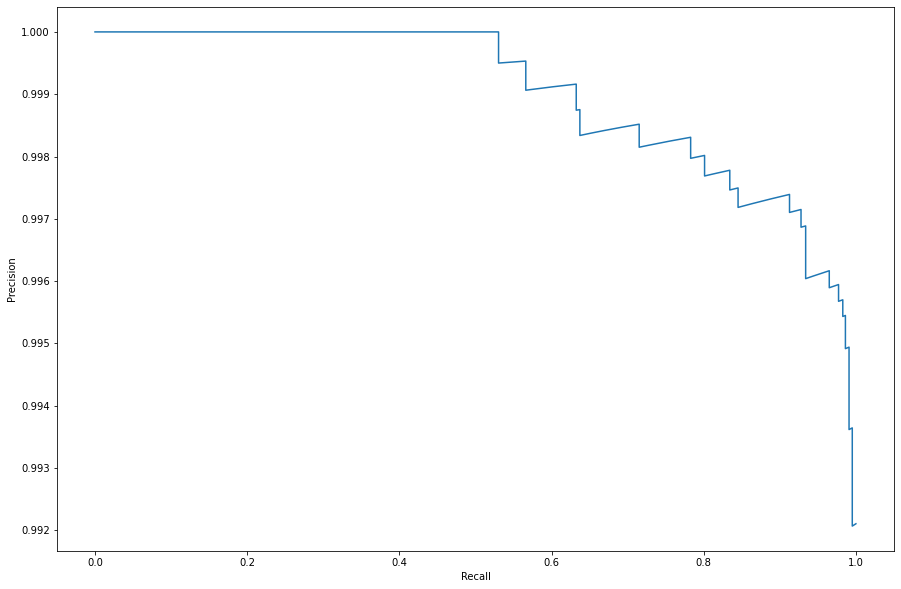

In [174]:
scorer = ['f1', 'recall', 'precision', 'accuracy', 'roc_auc']
refit = 'recall'
cross_val = [0, 2]

for cv_value in cross_val:
    
    #Oversampling
    ros = RandomOverSampler(random_state=42)
    X_train_scaled_ros, y_train_ros= ros.fit_resample(X_train_scaled, y_train)
    
    # grid search
    grid_search_clf = grid_search(xgb_cl, param_xgb, scorer, refit = refit, cross_val = cv_value)
    grid_search_clf.fit(X_train_scaled_ros, y_train_ros) # w drzewie nie muszą być dane zestandaryzowanne
    best_est = grid_search_clf.best_estimator_
    
    
    # Zebranie score'ów dla najlepszego klasyfikatora
    slownik_score = {}
    scorer_rank = 'rank_test_' + refit
    rank_min = grid_search_clf.cv_results_[scorer_rank].argmin()
    for sc in scorer:
        scorer_name = 'mean_test_' + sc
        scorer_value = grid_search_clf.cv_results_[scorer_name][rank_min]
        slownik_score[sc] = scorer_value

    #predykcja dla najlepszego estymatora wg recall
    y_pred = best_est.predict(X_train_scaled_ros)
    y_pred_proba = best_est.predict_proba(X_train_scaled_ros)[:,1]


    precision_c, recall_c, thresholds = precision_recall_curve(y_train_ros, y_pred_proba)


    print(f"Liczba kroswalidacji: {cv_value} \n \
Liczba obserwacji w zbiorze treningowym: {sorted(Counter(y_train_ros).items())} \n \
Sprawdzana metryka: {refit} \n \
Najlepsza wartość metryki: {grid_search_clf.best_score_} \n \
Najlepsze parametry: {grid_search_clf.best_params_} \n \
Macierz kontyngencji:")
    print(confusion_matrix(y_train_ros, y_pred))
    plt.figure(figsize=(15, 10))
    plt.plot(recall_c, precision_c)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    print(classification_report(y_train_ros, y_pred))

Liczba kroswalidacji: 0 
 Liczba obserwacji w zbiorze treningowym: [(0, 156), (1, 156)] 
 Sprawdzana metryka: recall 
 Najlepsza wartość metryki: 0.8153225806451612 
 Najlepsze parametry: {'booster': 'gbtree', 'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 10} 
 Macierz kontyngencji:
[[132  24]
 [ 15 141]]
              precision    recall  f1-score   support

           0       0.90      0.85      0.87       156
           1       0.85      0.90      0.88       156

    accuracy                           0.88       312
   macro avg       0.88      0.88      0.87       312
weighted avg       0.88      0.88      0.87       312

Liczba kroswalidacji: 2 
 Liczba obserwacji w zbiorze treningowym: [(0, 156), (1, 156)] 
 Sprawdzana metryka: recall 
 Najlepsza wartość metryki: 0.7948717948717949 
 Najlepsze parametry: {'booster': 'gbtree', 'learning_rate': 0.3, 'max_depth': 4, 'n_estimators': 10} 
 Macierz kontyngencji:
[[137  19]
 [ 13 143]]
              precision    recall  f1-score

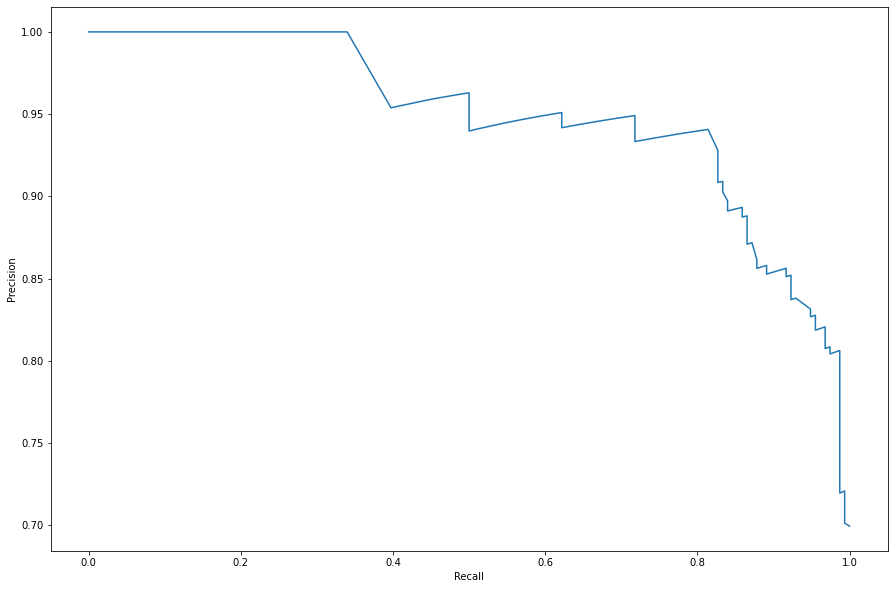

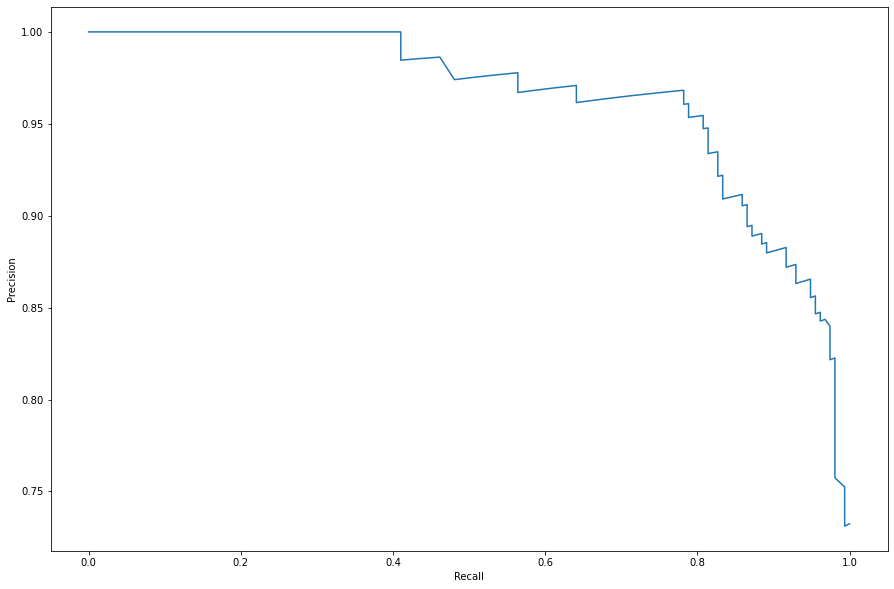

In [177]:
# grid search z undersamplingiem
scorer = ['f1', 'recall', 'precision', 'accuracy', 'roc_auc']
refit = 'recall'
cross_val = [0, 2]

for cv_value in cross_val:
    
    #Oversampling
    rus = RandomUnderSampler(random_state=42)
    X_train_scaled_rus, y_train_rus= rus.fit_resample(X_train_scaled, y_train)
    
    # grid search
    grid_search_clf = grid_search(xgb_cl, param_xgb, scorer, refit = refit, cross_val = cv_value)
    grid_search_clf.fit(X_train_scaled_rus, y_train_rus) # w drzewie nie muszą być dane zestandaryzowanne
    best_est = grid_search_clf.best_estimator_
    
    
    # Zebranie score'ów dla najlepszego klasyfikatora
    slownik_score = {}
    scorer_rank = 'rank_test_' + refit
    rank_min = grid_search_clf.cv_results_[scorer_rank].argmin()
    for sc in scorer:
        scorer_name = 'mean_test_' + sc
        scorer_value = grid_search_clf.cv_results_[scorer_name][rank_min]
        slownik_score[sc] = scorer_value

    #predykcja dla najlepszego estymatora wg recall
    y_pred = best_est.predict(X_train_scaled_rus)
    y_pred_proba = best_est.predict_proba(X_train_scaled_rus)[:,1]


    precision_c, recall_c, thresholds = precision_recall_curve(y_train_rus, y_pred_proba)


    print(f"Liczba kroswalidacji: {cv_value} \n \
Liczba obserwacji w zbiorze treningowym: {sorted(Counter(y_train_rus).items())} \n \
Sprawdzana metryka: {refit} \n \
Najlepsza wartość metryki: {grid_search_clf.best_score_} \n \
Najlepsze parametry: {grid_search_clf.best_params_} \n \
Macierz kontyngencji:")
    print(confusion_matrix(y_train_rus, y_pred))
    plt.figure(figsize=(15, 10))
    plt.plot(recall_c, precision_c)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    print(classification_report(y_train_rus, y_pred))

Liczba kroswalidacji: 0 
 Liczba obserwacji w zbiorze treningowym: [(0, 3771), (1, 3771)] 
 Sprawdzana metryka: recall 
 Najlepsza wartość metryki: 0.9644576387303037 
 Najlepsze parametry: {'booster': 'gbtree', 'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 50} 
 Macierz kontyngencji:
[[3749   22]
 [  20 3751]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3771
           1       0.99      0.99      0.99      3771

    accuracy                           0.99      7542
   macro avg       0.99      0.99      0.99      7542
weighted avg       0.99      0.99      0.99      7542

Liczba kroswalidacji: 2 
 Liczba obserwacji w zbiorze treningowym: [(0, 3771), (1, 3771)] 
 Sprawdzana metryka: recall 
 Najlepsza wartość metryki: 0.96101316133678 
 Najlepsze parametry: {'booster': 'gbtree', 'learning_rate': 0.8, 'max_depth': 7, 'n_estimators': 50} 
 Macierz kontyngencji:
[[3771    0]
 [   0 3771]]
              precision    recall

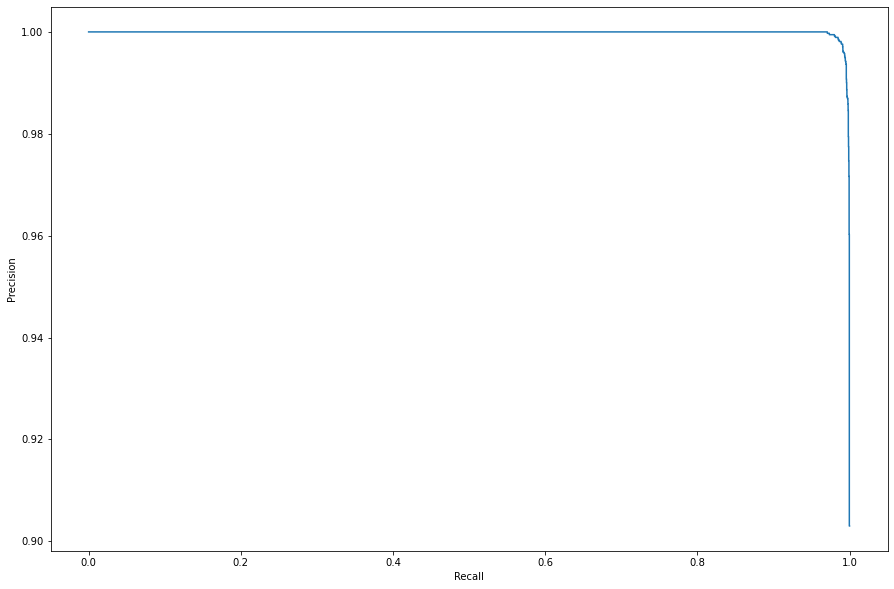

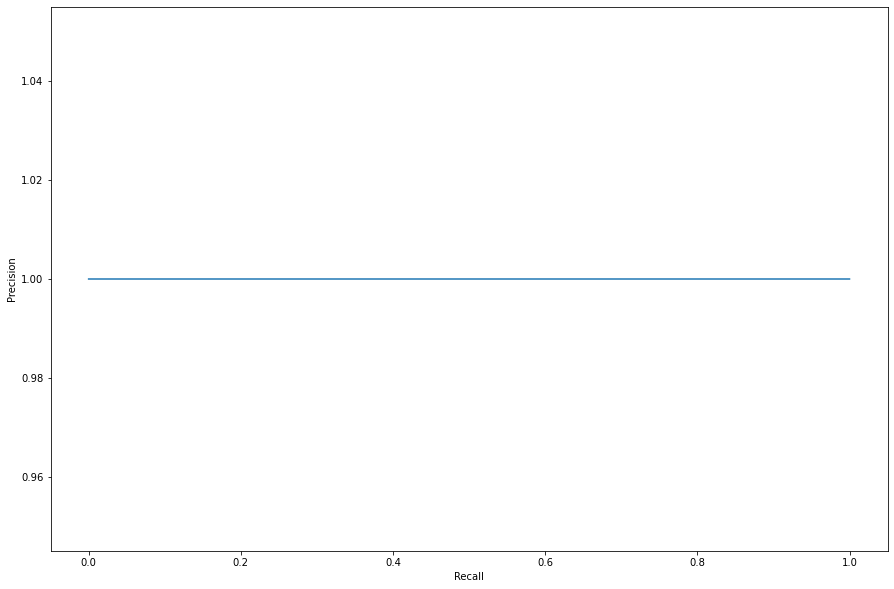

In [176]:
# grid search z SMOTE
scorer = ['f1', 'recall', 'precision', 'accuracy', 'roc_auc']
refit = 'recall'
cross_val = [0, 2]

for cv_value in cross_val:
    
    #Oversampling
    smt = SMOTE(random_state=42)
    X_train_scaled_smt, y_train_smt= smt.fit_resample(X_train_scaled, y_train)
    
    # grid search
    grid_search_clf = grid_search(xgb_cl, param_xgb, scorer, refit = refit, cross_val = cv_value)
    grid_search_clf.fit(X_train_scaled_smt, y_train_smt) # w drzewie nie muszą być dane zestandaryzowanne
    best_est = grid_search_clf.best_estimator_
    
    
    # Zebranie score'ów dla najlepszego klasyfikatora
    slownik_score = {}
    scorer_rank = 'rank_test_' + refit
    rank_min = grid_search_clf.cv_results_[scorer_rank].argmin()
    for sc in scorer:
        scorer_name = 'mean_test_' + sc
        scorer_value = grid_search_clf.cv_results_[scorer_name][rank_min]
        slownik_score[sc] = scorer_value

    #predykcja dla najlepszego estymatora wg recall
    y_pred = best_est.predict(X_train_scaled_smt)
    y_pred_proba = best_est.predict_proba(X_train_scaled_smt)[:,1]


    precision_c, recall_c, thresholds = precision_recall_curve(y_train_smt, y_pred_proba)


    print(f"Liczba kroswalidacji: {cv_value} \n \
Liczba obserwacji w zbiorze treningowym: {sorted(Counter(y_train_smt).items())} \n \
Sprawdzana metryka: {refit} \n \
Najlepsza wartość metryki: {grid_search_clf.best_score_} \n \
Najlepsze parametry: {grid_search_clf.best_params_} \n \
Macierz kontyngencji:")
    print(confusion_matrix(y_train_smt, y_pred))
    plt.figure(figsize=(15, 10))
    plt.plot(recall_c, precision_c)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    print(classification_report(y_train_smt, y_pred))

## Regresja logistyczna

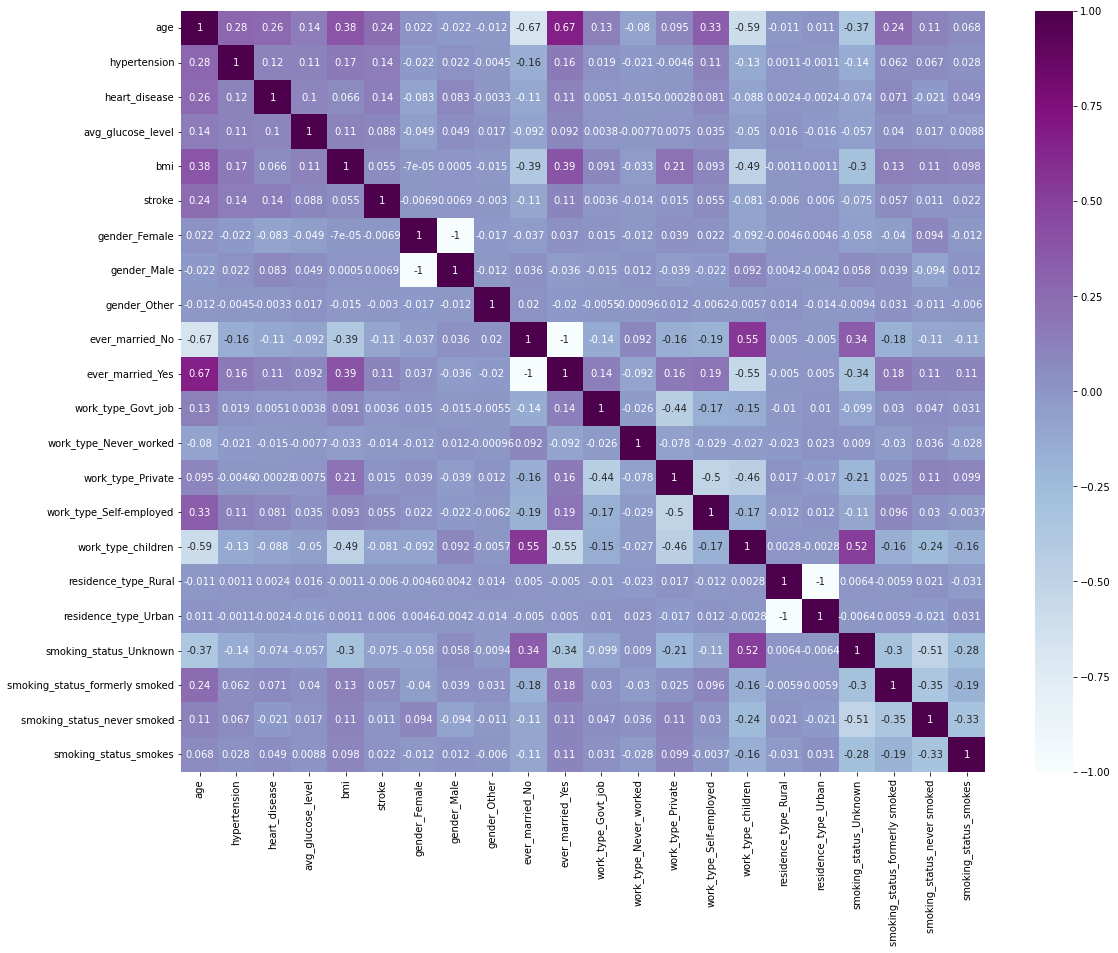

In [124]:
# Heatmapa dla korelacji
plt.figure(figsize = (18,14)) #rozmiar wykresu
sns.color_palette("viridis", as_cmap=True) #paleta kolorów, parametr as_cmap skaluje liczby na kolor (RGB)
Var_Corr = df.corr(method='spearman')
sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns, annot=True, cmap="BuPu");

In [130]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

In [131]:
X_train_scaled.columns

Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi',
       'gender_Female', 'gender_Male', 'gender_Other', 'ever_married_No',
       'ever_married_Yes', 'work_type_Govt_job', 'work_type_Never_worked',
       'work_type_Private', 'work_type_Self-employed', 'work_type_children',
       'residence_type_Rural', 'residence_type_Urban',
       'smoking_status_Unknown', 'smoking_status_formerly smoked',
       'smoking_status_never smoked', 'smoking_status_smokes'],
      dtype='object')

In [132]:
X_train_scaled = X_train_scaled.drop(['ever_married_No', 'ever_married_Yes', 'work_type_children'], axis=1)

In [135]:
X_train_scaled.columns

Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi',
       'gender_Female', 'gender_Male', 'gender_Other', 'work_type_Govt_job',
       'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'residence_type_Rural',
       'residence_type_Urban', 'smoking_status_Unknown',
       'smoking_status_formerly smoked', 'smoking_status_never smoked',
       'smoking_status_smokes'],
      dtype='object')

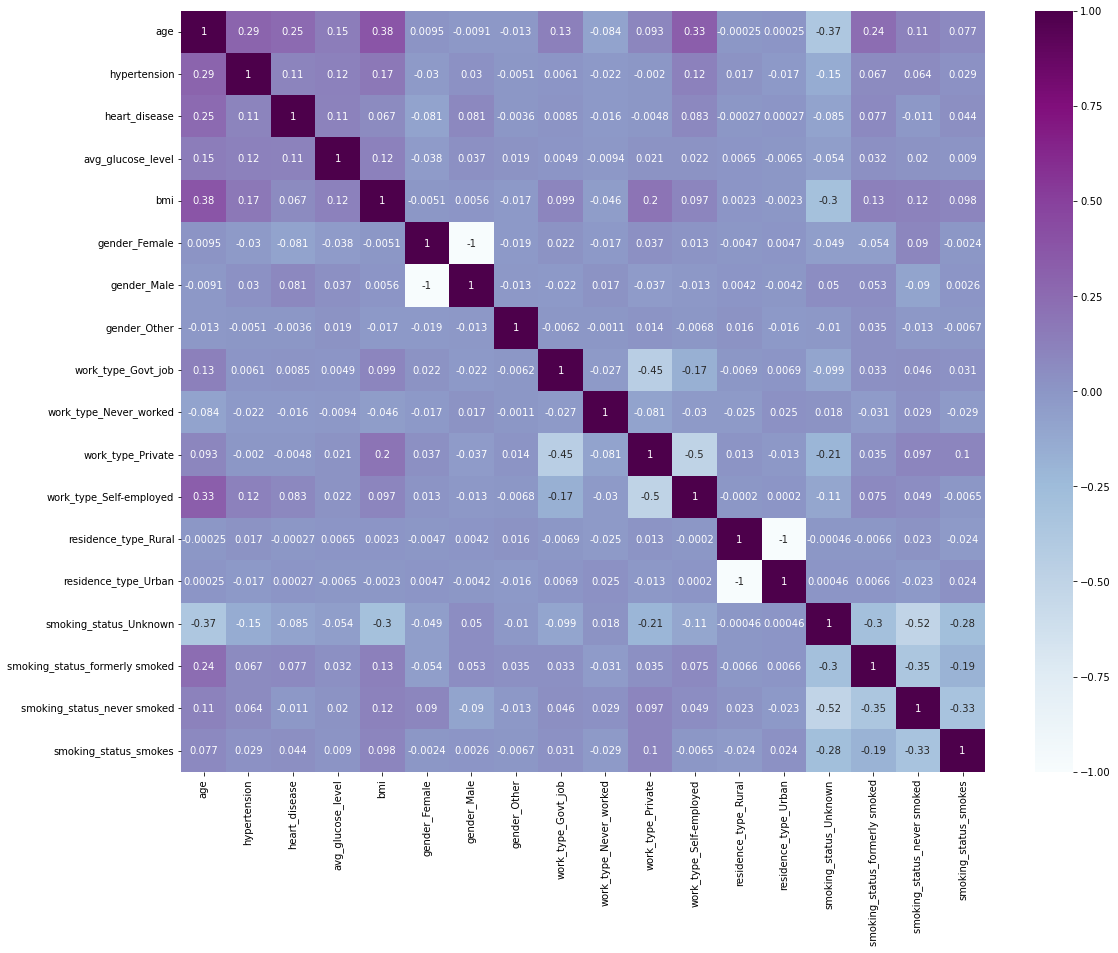

In [137]:
plt.figure(figsize = (18,14)) #rozmiar wykresu
sns.color_palette("viridis", as_cmap=True) #paleta kolorów, parametr as_cmap skaluje liczby na kolor (RGB)
Var_Corr = X_train_scaled.corr(method='spearman')
sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns, annot=True, cmap="BuPu");

In [139]:
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [140]:
X_test_scaled.columns

Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi',
       'gender_Female', 'gender_Male', 'gender_Other', 'ever_married_No',
       'ever_married_Yes', 'work_type_Govt_job', 'work_type_Never_worked',
       'work_type_Private', 'work_type_Self-employed', 'work_type_children',
       'residence_type_Rural', 'residence_type_Urban',
       'smoking_status_Unknown', 'smoking_status_formerly smoked',
       'smoking_status_never smoked', 'smoking_status_smokes'],
      dtype='object')

In [141]:
X_test_scaled = X_test_scaled.drop(['ever_married_No', 'ever_married_Yes', 'work_type_children'], axis=1)

In [142]:
X_test_scaled.columns

Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi',
       'gender_Female', 'gender_Male', 'gender_Other', 'work_type_Govt_job',
       'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'residence_type_Rural',
       'residence_type_Urban', 'smoking_status_Unknown',
       'smoking_status_formerly smoked', 'smoking_status_never smoked',
       'smoking_status_smokes'],
      dtype='object')

In [144]:
reg_log = LogisticRegression(random_state=42)

In [147]:
param_log = {}

F:\Anaconda\envs\projekt_python\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Anaconda\envs\projekt_python\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Anaconda\envs\projekt_python\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Anaconda\envs\projekt_python\lib\site-packages\sklearn\metrics\_classification.py:1318: Undefi

Liczba kroswalidacji: 0 
 Liczba obserwacji w zbiorze treningowym: [(0, 3771), (1, 156)] 
 Sprawdzana metryka: recall 
 Najlepsza wartość metryki: 0.0064516129032258064 
 Pozostałe score'y: {'f1': 0.0125, 'recall': 0.0064516129032258064, 'precision': 0.2, 'accuracy': 0.960529975202995, 'roc_auc': 0.8410753362257377} 
 
 Najlepsze parametry: {} 
 Macierz kontyngencji:
[[3771    0]
 [ 155    1]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3771
           1       1.00      0.01      0.01       156

    accuracy                           0.96      3927
   macro avg       0.98      0.50      0.50      3927
weighted avg       0.96      0.96      0.94      3927

Liczba kroswalidacji: 2 
 Liczba obserwacji w zbiorze treningowym: [(0, 3771), (1, 156)] 
 Sprawdzana metryka: recall 
 Najlepsza wartość metryki: 0.01282051282051282 
 Pozostałe score'y: {'f1': 0.025, 'recall': 0.01282051282051282, 'precision': 0.5, 'accuracy': 0.96078444087

F:\Anaconda\envs\projekt_python\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Anaconda\envs\projekt_python\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Anaconda\envs\projekt_python\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Anaconda\envs\projekt_python\lib\site-packages\sklearn\metrics\_classification.py:1318: Undefi

Liczba kroswalidacji: 5 
 Liczba obserwacji w zbiorze treningowym: [(0, 3771), (1, 156)] 
 Sprawdzana metryka: recall 
 Najlepsza wartość metryki: 0.0064516129032258064 
 Pozostałe score'y: {'f1': 0.0125, 'recall': 0.0064516129032258064, 'precision': 0.2, 'accuracy': 0.960529975202995, 'roc_auc': 0.8410753362257377} 
 
 Najlepsze parametry: {} 
 Macierz kontyngencji:
[[3771    0]
 [ 155    1]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3771
           1       1.00      0.01      0.01       156

    accuracy                           0.96      3927
   macro avg       0.98      0.50      0.50      3927
weighted avg       0.96      0.96      0.94      3927

Liczba kroswalidacji: 10 
 Liczba obserwacji w zbiorze treningowym: [(0, 3771), (1, 156)] 
 Sprawdzana metryka: recall 
 Najlepsza wartość metryki: 0.00625 
 Pozostałe score'y: {'f1': 0.011764705882352941, 'recall': 0.00625, 'precision': 0.1, 'accuracy': 0.9605305862803137, '

F:\Anaconda\envs\projekt_python\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Anaconda\envs\projekt_python\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Anaconda\envs\projekt_python\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Anaconda\envs\projekt_python\lib\site-packages\sklearn\metrics\_classification.py:1318: Undefi

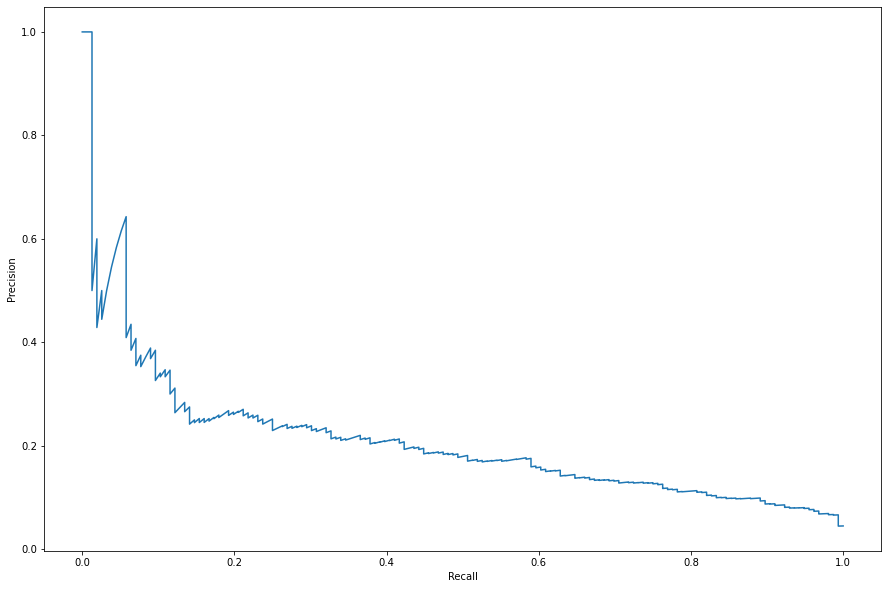

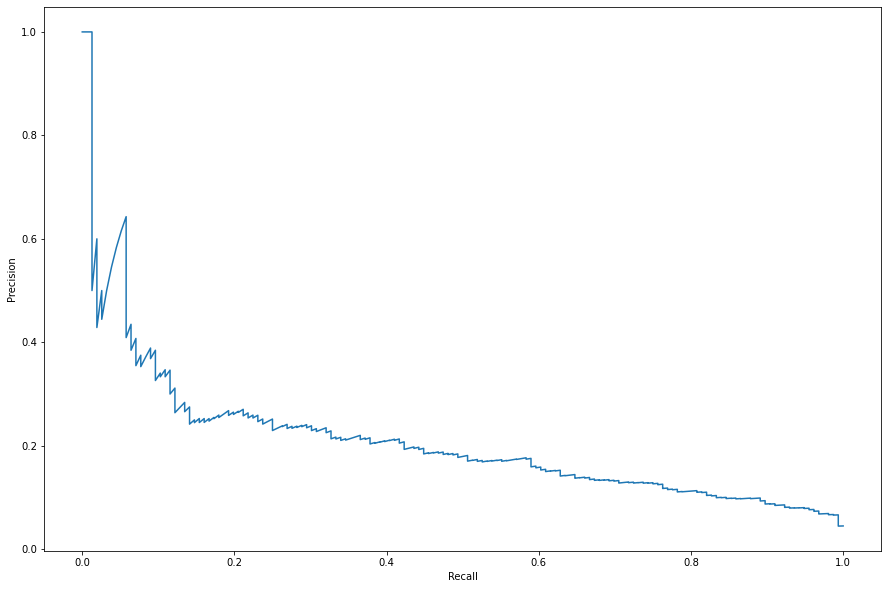

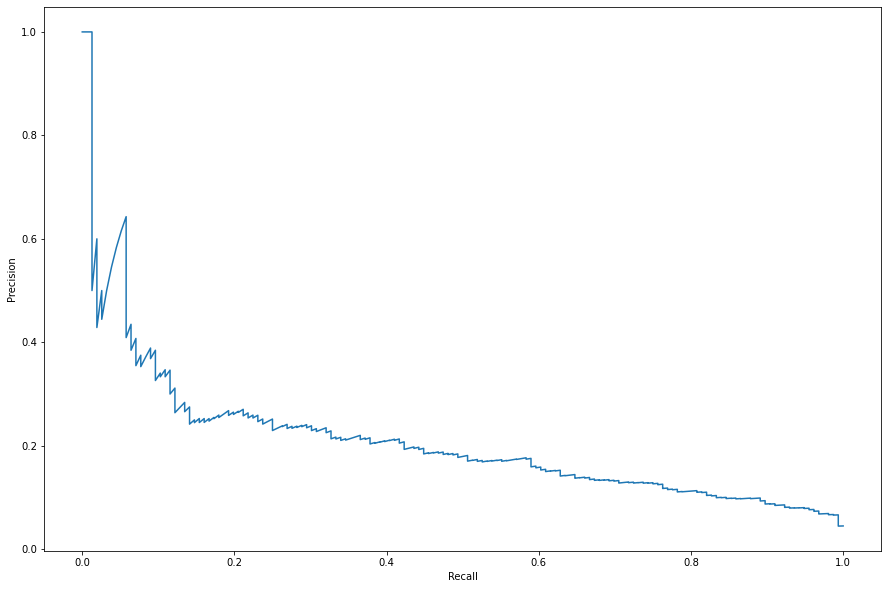

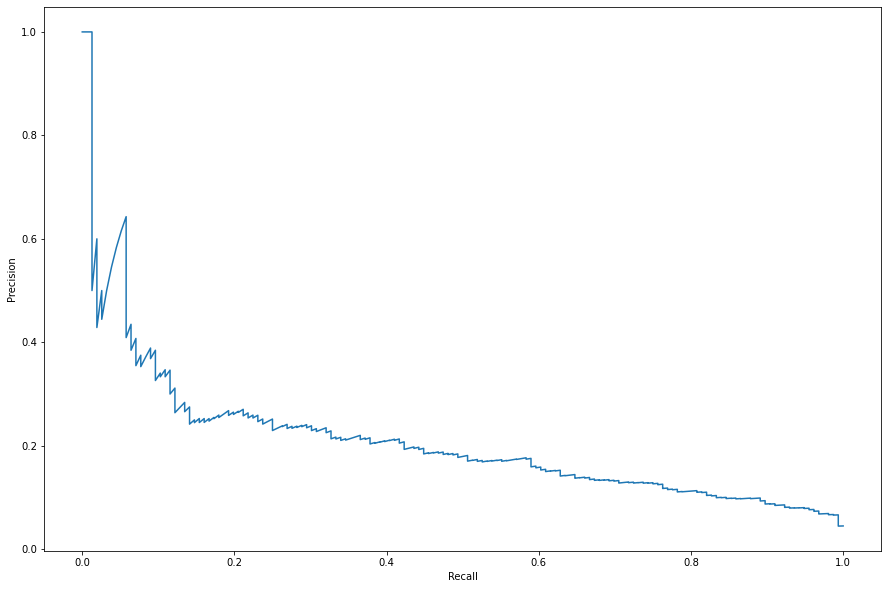

In [148]:
scorer = ['f1', 'recall', 'precision', 'accuracy', 'roc_auc']
refit = 'recall'
cross_val = [0, 2, 5, 10]

for cv_value in cross_val:

    # grid search
    grid_search_clf = grid_search(reg_log, param_log, scorer, refit = refit, cross_val = cv_value)
    grid_search_clf.fit(X_train_scaled, y_train) # w drzewie nie muszą być dane zestandaryzowanne
    best_est = grid_search_clf.best_estimator_
    
    # Zebranie score'ów dla najlepszego klasyfikatora
    slownik_score = {}
    scorer_rank = 'rank_test_' + refit
    rank_min = grid_search_clf.cv_results_[scorer_rank].argmin()
    for sc in scorer:
        scorer_name = 'mean_test_' + sc
        scorer_value = grid_search_clf.cv_results_[scorer_name][rank_min]
        slownik_score[sc] = scorer_value

    #predykcja dla najlepszego estymatora wg recall
    y_pred = best_est.predict(X_train_scaled)
    y_pred_proba = best_est.predict_proba(X_train_scaled)[:,1]


    precision_c, recall_c, thresholds = precision_recall_curve(y_train, y_pred_proba)


    print(f"Liczba kroswalidacji: {cv_value} \n \
Liczba obserwacji w zbiorze treningowym: {sorted(Counter(y_train).items())} \n \
Sprawdzana metryka: {refit} \n \
Najlepsza wartość metryki: {grid_search_clf.best_score_} \n \
Pozostałe score'y: {slownik_score} \n \
\n \
Najlepsze parametry: {grid_search_clf.best_params_} \n \
Macierz kontyngencji:")
    print(confusion_matrix(y_train, y_pred))
    plt.figure(figsize=(15, 10))
    plt.plot(recall_c, precision_c)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    print(classification_report(y_train, y_pred))

Liczba kroswalidacji: 0 
 Liczba obserwacji w zbiorze treningowym: [(0, 3771), (1, 3771)] 
 Sprawdzana metryka: recall 
 Najlepsza wartość metryki: 0.7963363606021747 
 Najlepsze parametry: {} 
 Macierz kontyngencji:
[[2771 1000]
 [ 772 2999]]
              precision    recall  f1-score   support

           0       0.78      0.73      0.76      3771
           1       0.75      0.80      0.77      3771

    accuracy                           0.77      7542
   macro avg       0.77      0.77      0.76      7542
weighted avg       0.77      0.77      0.76      7542

Liczba kroswalidacji: 2 
 Liczba obserwacji w zbiorze treningowym: [(0, 3771), (1, 3771)] 
 Sprawdzana metryka: recall 
 Najlepsza wartość metryki: 0.794748123124179 
 Najlepsze parametry: {} 
 Macierz kontyngencji:
[[2771 1000]
 [ 772 2999]]
              precision    recall  f1-score   support

           0       0.78      0.73      0.76      3771
           1       0.75      0.80      0.77      3771

    accuracy          

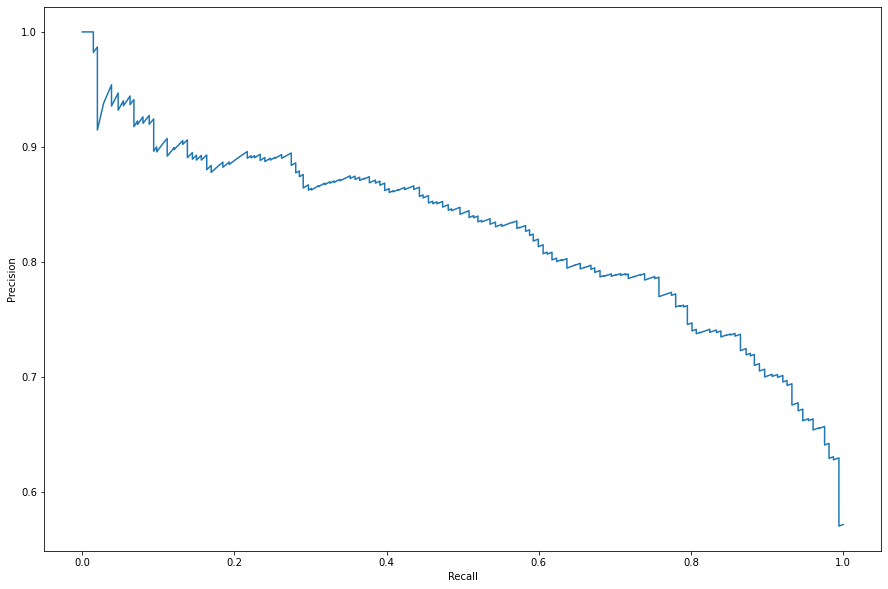

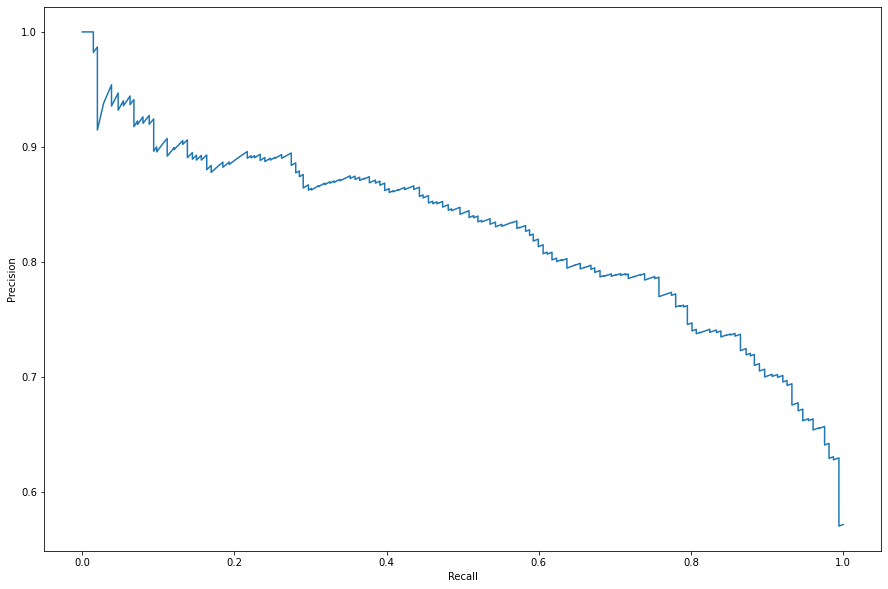

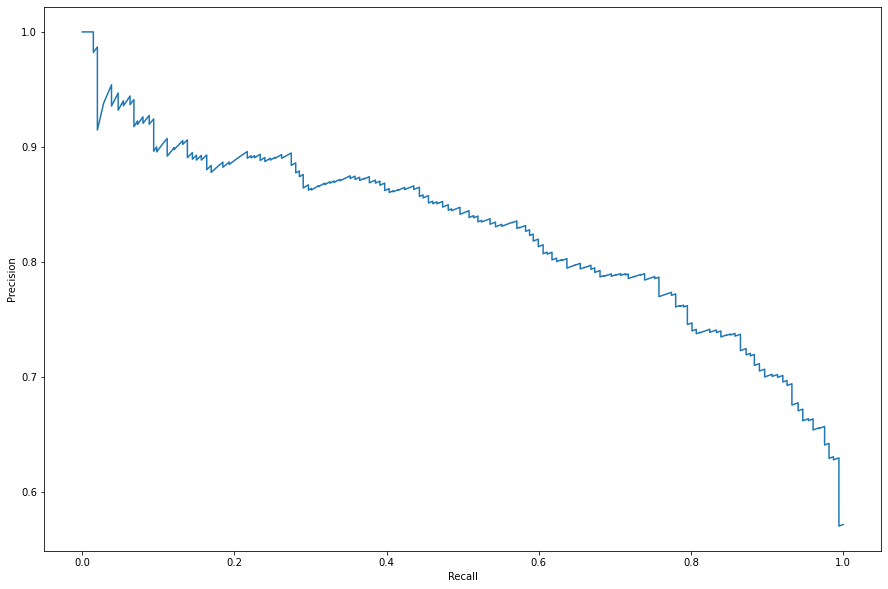

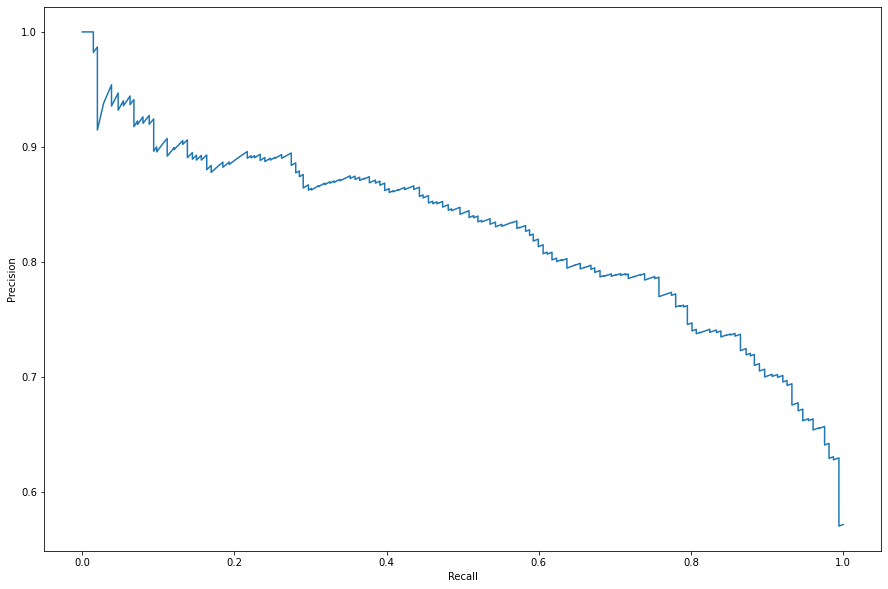

In [149]:
scorer = ['f1', 'recall', 'precision', 'accuracy', 'roc_auc']
refit = 'recall'
cross_val = [0, 2, 5, 10]

for cv_value in cross_val:
    
    #Oversampling
    ros = RandomOverSampler(random_state=42)
    X_train_scaled_ros, y_train_ros= ros.fit_resample(X_train_scaled, y_train)
    
    # grid search
    grid_search_clf = grid_search(reg_log, param_log, scorer, refit = refit, cross_val = cv_value)
    grid_search_clf.fit(X_train_scaled_ros, y_train_ros) # w drzewie nie muszą być dane zestandaryzowanne
    best_est = grid_search_clf.best_estimator_
    
    
    # Zebranie score'ów dla najlepszego klasyfikatora
    slownik_score = {}
    scorer_rank = 'rank_test_' + refit
    rank_min = grid_search_clf.cv_results_[scorer_rank].argmin()
    for sc in scorer:
        scorer_name = 'mean_test_' + sc
        scorer_value = grid_search_clf.cv_results_[scorer_name][rank_min]
        slownik_score[sc] = scorer_value

    #predykcja dla najlepszego estymatora wg recall
    y_pred = best_est.predict(X_train_scaled_ros)
    y_pred_proba = best_est.predict_proba(X_train_scaled_ros)[:,1]


    precision_c, recall_c, thresholds = precision_recall_curve(y_train_ros, y_pred_proba)


    print(f"Liczba kroswalidacji: {cv_value} \n \
Liczba obserwacji w zbiorze treningowym: {sorted(Counter(y_train_ros).items())} \n \
Sprawdzana metryka: {refit} \n \
Najlepsza wartość metryki: {grid_search_clf.best_score_} \n \
Najlepsze parametry: {grid_search_clf.best_params_} \n \
Macierz kontyngencji:")
    print(confusion_matrix(y_train_ros, y_pred))
    plt.figure(figsize=(15, 10))
    plt.plot(recall_c, precision_c)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    print(classification_report(y_train_ros, y_pred))

Liczba kroswalidacji: 0 
 Liczba obserwacji w zbiorze treningowym: [(0, 156), (1, 156)] 
 Sprawdzana metryka: recall 
 Najlepsza wartość metryki: 0.7832661290322581 
 Najlepsze parametry: {} 
 Macierz kontyngencji:
[[120  36]
 [ 24 132]]
              precision    recall  f1-score   support

           0       0.83      0.77      0.80       156
           1       0.79      0.85      0.81       156

    accuracy                           0.81       312
   macro avg       0.81      0.81      0.81       312
weighted avg       0.81      0.81      0.81       312

Liczba kroswalidacji: 2 
 Liczba obserwacji w zbiorze treningowym: [(0, 156), (1, 156)] 
 Sprawdzana metryka: recall 
 Najlepsza wartość metryki: 0.7564102564102564 
 Najlepsze parametry: {} 
 Macierz kontyngencji:
[[120  36]
 [ 24 132]]
              precision    recall  f1-score   support

           0       0.83      0.77      0.80       156
           1       0.79      0.85      0.81       156

    accuracy                     

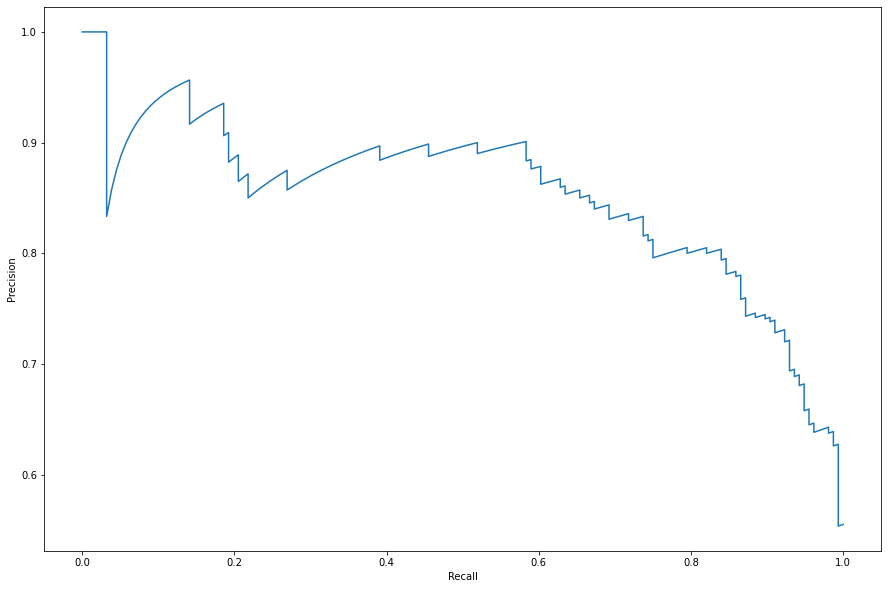

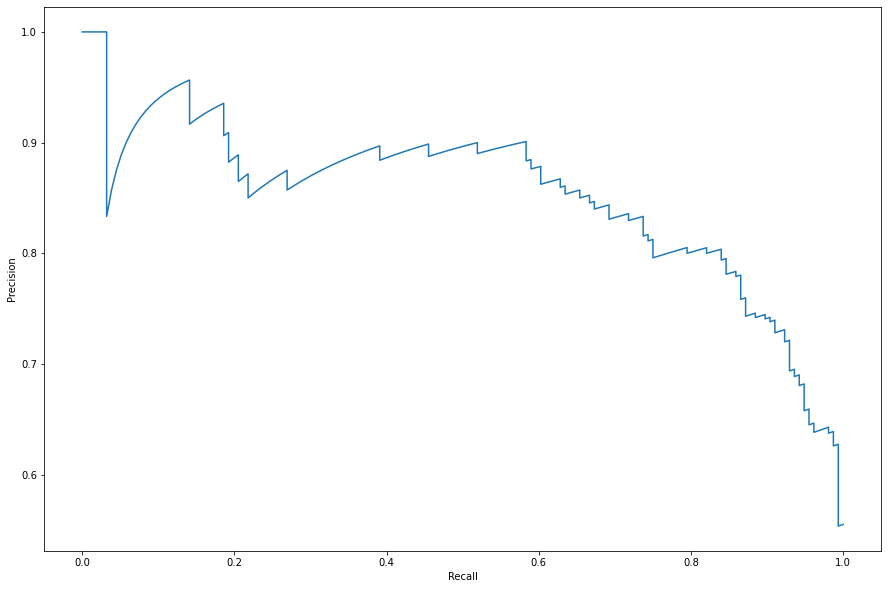

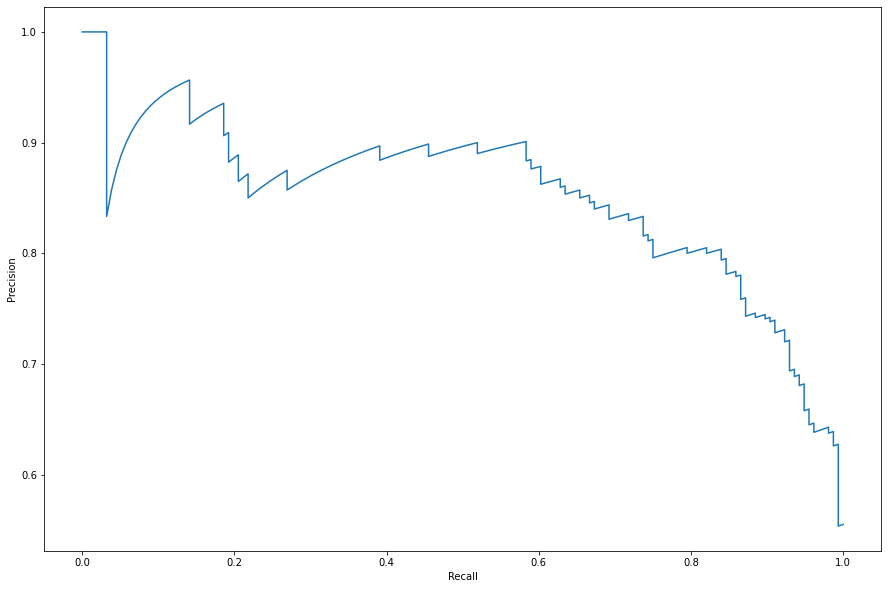

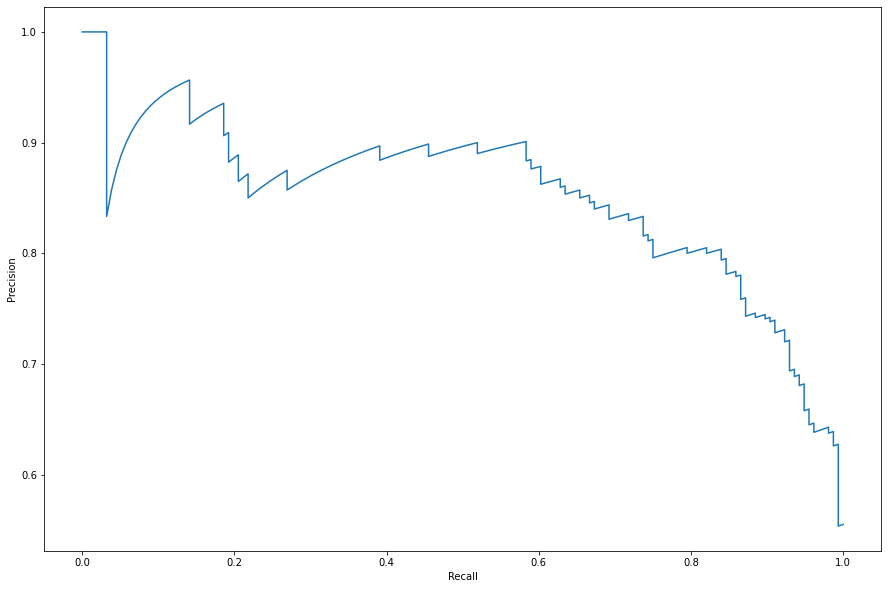

In [150]:
# grid search z undersamplingiem
scorer = ['f1', 'recall', 'precision', 'accuracy', 'roc_auc']
refit = 'recall'
cross_val = [0, 2, 5, 10]

for cv_value in cross_val:
    
    #Oversampling
    rus = RandomUnderSampler(random_state=42)
    X_train_scaled_rus, y_train_rus= rus.fit_resample(X_train_scaled, y_train)
    
    # grid search
    grid_search_clf = grid_search(reg_log, param_log, scorer, refit = refit, cross_val = cv_value)
    grid_search_clf.fit(X_train_scaled_rus, y_train_rus) # w drzewie nie muszą być dane zestandaryzowanne
    best_est = grid_search_clf.best_estimator_
    
    
    # Zebranie score'ów dla najlepszego klasyfikatora
    slownik_score = {}
    scorer_rank = 'rank_test_' + refit
    rank_min = grid_search_clf.cv_results_[scorer_rank].argmin()
    for sc in scorer:
        scorer_name = 'mean_test_' + sc
        scorer_value = grid_search_clf.cv_results_[scorer_name][rank_min]
        slownik_score[sc] = scorer_value

    #predykcja dla najlepszego estymatora wg recall
    y_pred = best_est.predict(X_train_scaled_rus)
    y_pred_proba = best_est.predict_proba(X_train_scaled_rus)[:,1]


    precision_c, recall_c, thresholds = precision_recall_curve(y_train_rus, y_pred_proba)


    print(f"Liczba kroswalidacji: {cv_value} \n \
Liczba obserwacji w zbiorze treningowym: {sorted(Counter(y_train_rus).items())} \n \
Sprawdzana metryka: {refit} \n \
Najlepsza wartość metryki: {grid_search_clf.best_score_} \n \
Najlepsze parametry: {grid_search_clf.best_params_} \n \
Macierz kontyngencji:")
    print(confusion_matrix(y_train_rus, y_pred))
    plt.figure(figsize=(15, 10))
    plt.plot(recall_c, precision_c)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    print(classification_report(y_train_rus, y_pred))

Liczba kroswalidacji: 0 
 Liczba obserwacji w zbiorze treningowym: [(0, 3771), (1, 3771)] 
 Sprawdzana metryka: recall 
 Najlepsza wartość metryki: 0.8363827357844258 
 Najlepsze parametry: {} 
 Macierz kontyngencji:
[[2817  954]
 [ 621 3150]]
              precision    recall  f1-score   support

           0       0.82      0.75      0.78      3771
           1       0.77      0.84      0.80      3771

    accuracy                           0.79      7542
   macro avg       0.79      0.79      0.79      7542
weighted avg       0.79      0.79      0.79      7542

Liczba kroswalidacji: 2 
 Liczba obserwacji w zbiorze treningowym: [(0, 3771), (1, 3771)] 
 Sprawdzana metryka: recall 
 Najlepsza wartość metryki: 0.833729476725052 
 Najlepsze parametry: {} 
 Macierz kontyngencji:
[[2817  954]
 [ 621 3150]]
              precision    recall  f1-score   support

           0       0.82      0.75      0.78      3771
           1       0.77      0.84      0.80      3771

    accuracy          

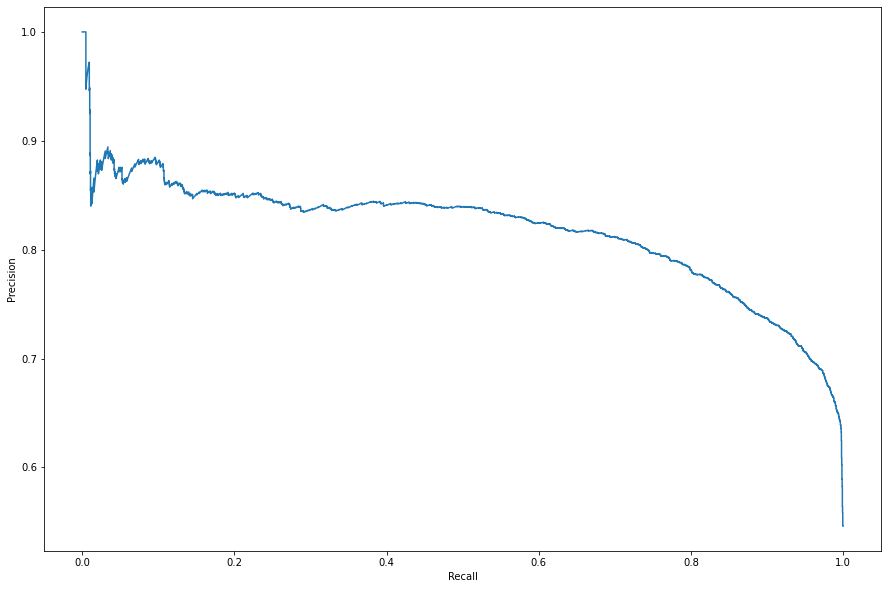

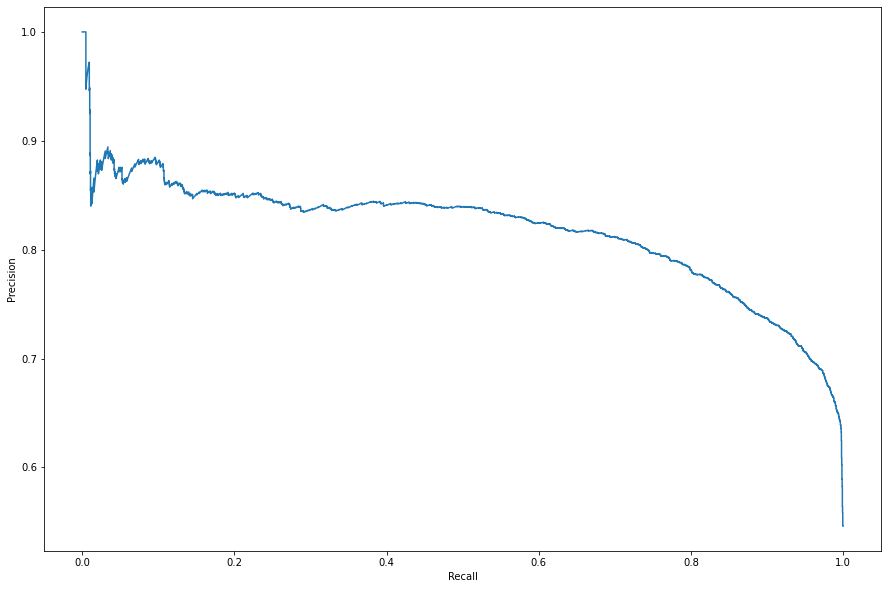

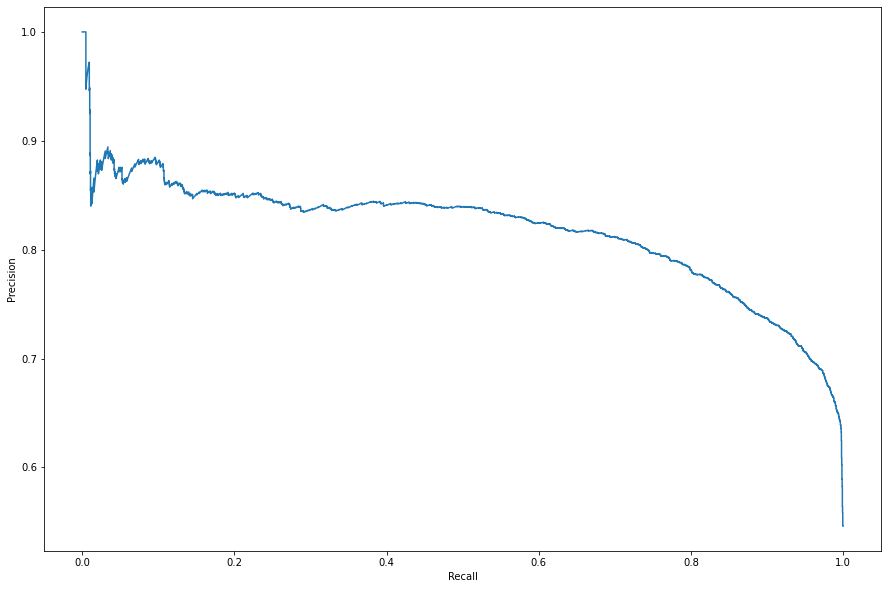

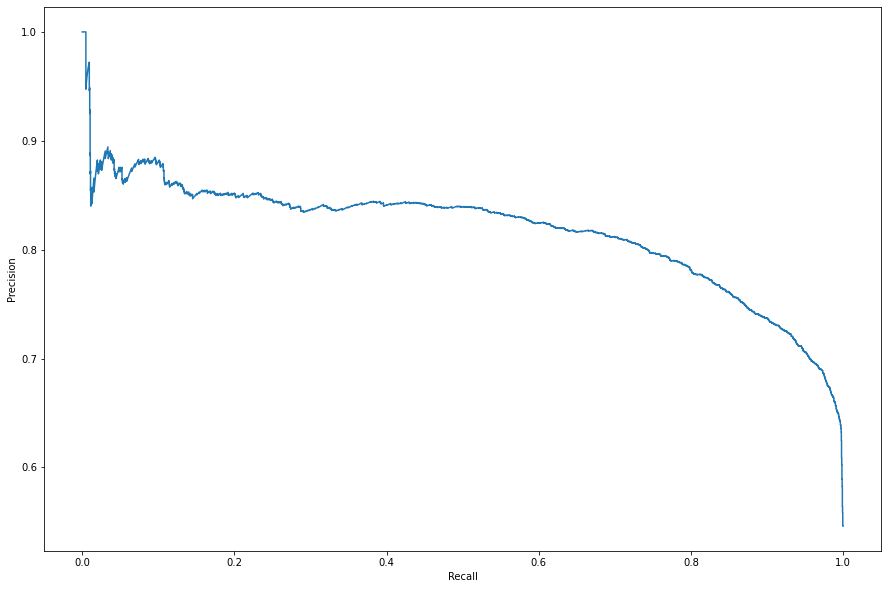

In [151]:
# grid search z SMOTE
scorer = ['f1', 'recall', 'precision', 'accuracy', 'roc_auc']
refit = 'recall'
cross_val = [0, 2, 5, 10]

for cv_value in cross_val:
    
    #Oversampling
    smt = SMOTE(random_state=42)
    X_train_scaled_smt, y_train_smt= smt.fit_resample(X_train_scaled, y_train)
    
    # grid search
    grid_search_clf = grid_search(reg_log, param_log, scorer, refit = refit, cross_val = cv_value)
    grid_search_clf.fit(X_train_scaled_smt, y_train_smt) # w drzewie nie muszą być dane zestandaryzowanne
    best_est = grid_search_clf.best_estimator_
    
    
    # Zebranie score'ów dla najlepszego klasyfikatora
    slownik_score = {}
    scorer_rank = 'rank_test_' + refit
    rank_min = grid_search_clf.cv_results_[scorer_rank].argmin()
    for sc in scorer:
        scorer_name = 'mean_test_' + sc
        scorer_value = grid_search_clf.cv_results_[scorer_name][rank_min]
        slownik_score[sc] = scorer_value

    #predykcja dla najlepszego estymatora wg recall
    y_pred = best_est.predict(X_train_scaled_smt)
    y_pred_proba = best_est.predict_proba(X_train_scaled_smt)[:,1]


    precision_c, recall_c, thresholds = precision_recall_curve(y_train_smt, y_pred_proba)


    print(f"Liczba kroswalidacji: {cv_value} \n \
Liczba obserwacji w zbiorze treningowym: {sorted(Counter(y_train_smt).items())} \n \
Sprawdzana metryka: {refit} \n \
Najlepsza wartość metryki: {grid_search_clf.best_score_} \n \
Najlepsze parametry: {grid_search_clf.best_params_} \n \
Macierz kontyngencji:")
    print(confusion_matrix(y_train_smt, y_pred))
    plt.figure(figsize=(15, 10))
    plt.plot(recall_c, precision_c)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    print(classification_report(y_train_smt, y_pred))

In [ ]:
# # Możliwe metryki do wybrania w GridSearch
# import sklearn.metrics as m
# m.get_scorer_names()

https://towardsdatascience.com/micro-macro-weighted-averages-of-f1-score-clearly-explained-b603420b292f - rozkmina na temat micro, macro, weighted f1 - chyba z tego wychodzi, że powinniśmy brać macro

## Pytania:
- Czy da się narysować wykres precision_recall dla zbioru walidacyjnego z gridSearcha i czy ma to sens ? 
- Czy to poprawne, że przy gridsearchu dla różnych ilości kroswalidacji wychodzą te same modele i metryki ?